# Modules 

In [197]:
import os
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import datetime
import scipy.stats as stats
import re
import time
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from graphviz import Source
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV , ShuffleSplit
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score


%matplotlib inline 

In [3]:
pd.set_option('display.max_rows', 100)

# Functions

In [4]:
def plot_data(df,var,query=False):
    '''
    Input: 
    df = Dataframe
    var = column of interest.
    query = bool to select section from Distribution 
    
    Output: 
    Plots showing a bar chart for col of interest.
    
    Retrun: 
    If query is True, a list of columns within range. 
    
    '''
    
    # If bool is true, user Input is necessary
    if query: 
        t_u=int(input("Enter max. threshold "))
        t_l=int(input("Enter min. threshold "))
        df=df[(df[var]<=t_u)&(df[var]>t_l)]
        col_list=df['Column namnes'].to_list()
    
    # Creating a plot based on df and var
    df=df.sort_values(var,ascending=False)
    
    # Defining plot 
    sns.set(font_scale = 2)
    f, ax = plt.subplots(figsize=(20, 25))
    sns.set_color_codes("pastel")
    sns.barplot(x=var, y="Column namnes", data=df, color='b')
    plt.suptitle("Percentage of {} per Column".format(var), size=25)
    
    # If query not true, plot ax-line at 50%-mark
    if not query: 
        plt.axvline(50, 0,100, color='red') 
        
    # If query is true, add additional title with threshold range        
    if query: 
        plt.title('Threshold Range from {} to {}'.format(t_l,t_u), size=20)
        return col_list

In [5]:
def remove_dollar(df):
    '''
    Input:
    df = Dataframe of choice
    
    Return: 
    Dataframe without $-Symbols in col
    '''
    
    # Defining list of columns 
    df_obj='price','cleaning_fee','extra_people'
    
    # Iterating over columns 
    for col in df_obj:
        try:
            df[col]=df[col].apply(lambda x: str(x).replace('$',''))
            df[col]=df[col].apply(lambda x: x.replace(',',''))
            df[col]=df[col].astype(float)
        except KeyError:
            print("{} is not in Dataset".format(col))
            
    return df

In [6]:
def int_to_str(df,col):
    '''
    Input: 
    df = Dataframe 
    col = Column of Choice 
    
    Return:
    Dataframe with converted col (from int to str)
    '''
    
    df[col]=df[col].astype(str)
    return df 

In [7]:
def remove_t_f(df):
    '''
    Input: 
    df = Dataframe
    
    Return: 
    Dataframe where t- or f- values \
    are encoded in 0 or 1 
    '''
    
    # Selecting var's with t/f-values
    df_obj= "host_is_superhost","host_has_profile_pic", "host_identity_verified", \
    "is_location_exact","has_availability","instant_bookable", "require_guest_profile_picture", \
    "require_guest_phone_verification"
    
    # Iterating over dataset in refernce to list.
    # Where f or t is founed, changed to 0 or 1. 
    # Else is copied. 
    
    for col in df_obj: 
        try:
            df[col]=np.where(df[col]=='f','0',
                         (np.where(df[col]=='t','1',df[col])))
            df[col]=df[col].astype(object)
        except KeyError: 
            print("{} is not in Dataset".format(col))
    return df

In [8]:
def remove_percent (df):
    '''
    Input:
    df = Dataframe
    
    Return: 
    Dataframe where %-symbol is removed 
    
    '''
    # Selecting objects with % 
    df_obj='host_response_rate', 'host_acceptance_rate'
    
    # Iterating over objects 
    for col in df_obj:
        df[col]=df[col].apply(lambda x: str(x).replace('%',''))
        df[col]=df[col].astype(float)
        df[col]=df[col]/100
        
    return df 

In [182]:
def grid_rf(X_train, Y_train):
    '''
    Input: 
    X_train = x_sample of split 
    Y_train = y_sample of split 
    
    Return: 
    
    best mae of gridsearch and best params of gridsearch 
    '''
    
    estimator = RandomForestRegressor(random_state = 42)
    param_grid = { 
            "bootstrap": [True],
            'max_depth': [10,20,30,35,40],
            "n_estimators"      : [30,40,50,100,250,500,1000],
            "max_features"      : ["auto", "sqrt"],
            "min_samples_split" : [2,3,4,5,8,10],
            "oob_score": [True,False]
            }

    grid = GridSearchCV(estimator, param_grid=param_grid,
                        scoring='neg_mean_absolute_error', n_jobs=-1,cv=5)

    grid.fit(X_train, Y_train)

    return grid.best_score_ , grid.best_params_

# Research Question 

1) How much does Neighbourhood effect pricing ? <br>
2) Does seasonality effect pricing ?  <br>
3) How do amenities relate to price ?  <br>
4) What factor has the most impact on Pricing ? 

# Datasets - Inspection and Preparation

## Listings-Data

### Inspecting and Cleaning 

In [11]:
df=pd.read_csv((os.getcwd()+'\\')+'listings.csv',sep=',')

In [12]:
print(df.columns)

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

The data set consists of many columns and is difficult to overview. Therefore I am going to create a meta data set with column information.  

#### Meta-Data Analysis

In [28]:
# Iterating over columns, and creating a dataset with meta information

col=df.columns
l=[]
for i in col:
    # Excluding Summary, as it is text var.
    if i !='summary':
        try:
            case={'Column namnes':i, 'Missing in %': (round((df[i].isna().sum()/df.shape[0])*100)), \
                  'Unique Values': (df[i].nunique()), 'Unique Values in %':((df[i].nunique())/df.shape[0]*100),  
                  'Value Counts': df[i].value_counts(),'Type':str((df[i].dtypes))}
            l.append(case)
        except: 
            pass      
        df_info=pd.DataFrame.from_dict(l)   
    else: 
        pass
    
# The meta data schows several column based information 
df_info

,Column namnes,Missing in %,Unique Values,Unique Values in %,Value Counts,Type
0,id,0.0,3818,100.000000,8849407 1 9362082 1 5364414 1 5062445...,int64
1,listing_url,0.0,3818,100.000000,https://www.airbnb.com/rooms/7024684 1 htt...,object
2,scrape_id,0.0,1,0.026192,"20160104002432 3818 Name: scrape_id, dtype:...",int64
3,last_scraped,0.0,1,0.026192,"2016-01-04 3818 Name: last_scraped, dtype: ...",object
4,name,0.0,3792,99.319015,Capitol Hill Apartment 3 Sans ...,object
5,space,15.0,3119,81.691985,"*Note: This fall, there will be major renovati...",object
6,description,0.0,3742,98.009429,Our space is a mix of a hostel and a home. We ...,object
7,experiences_offered,0.0,1,0.026192,"none 3818 Name: experiences_offered, dtype:...",object
8,neighborhood_overview,27.0,2506,65.636459,Wallingford is a mostly-residential neighborho...,object
9,notes,42.0,1999,52.357255,All of our rentals are fully licensed and regu...,object


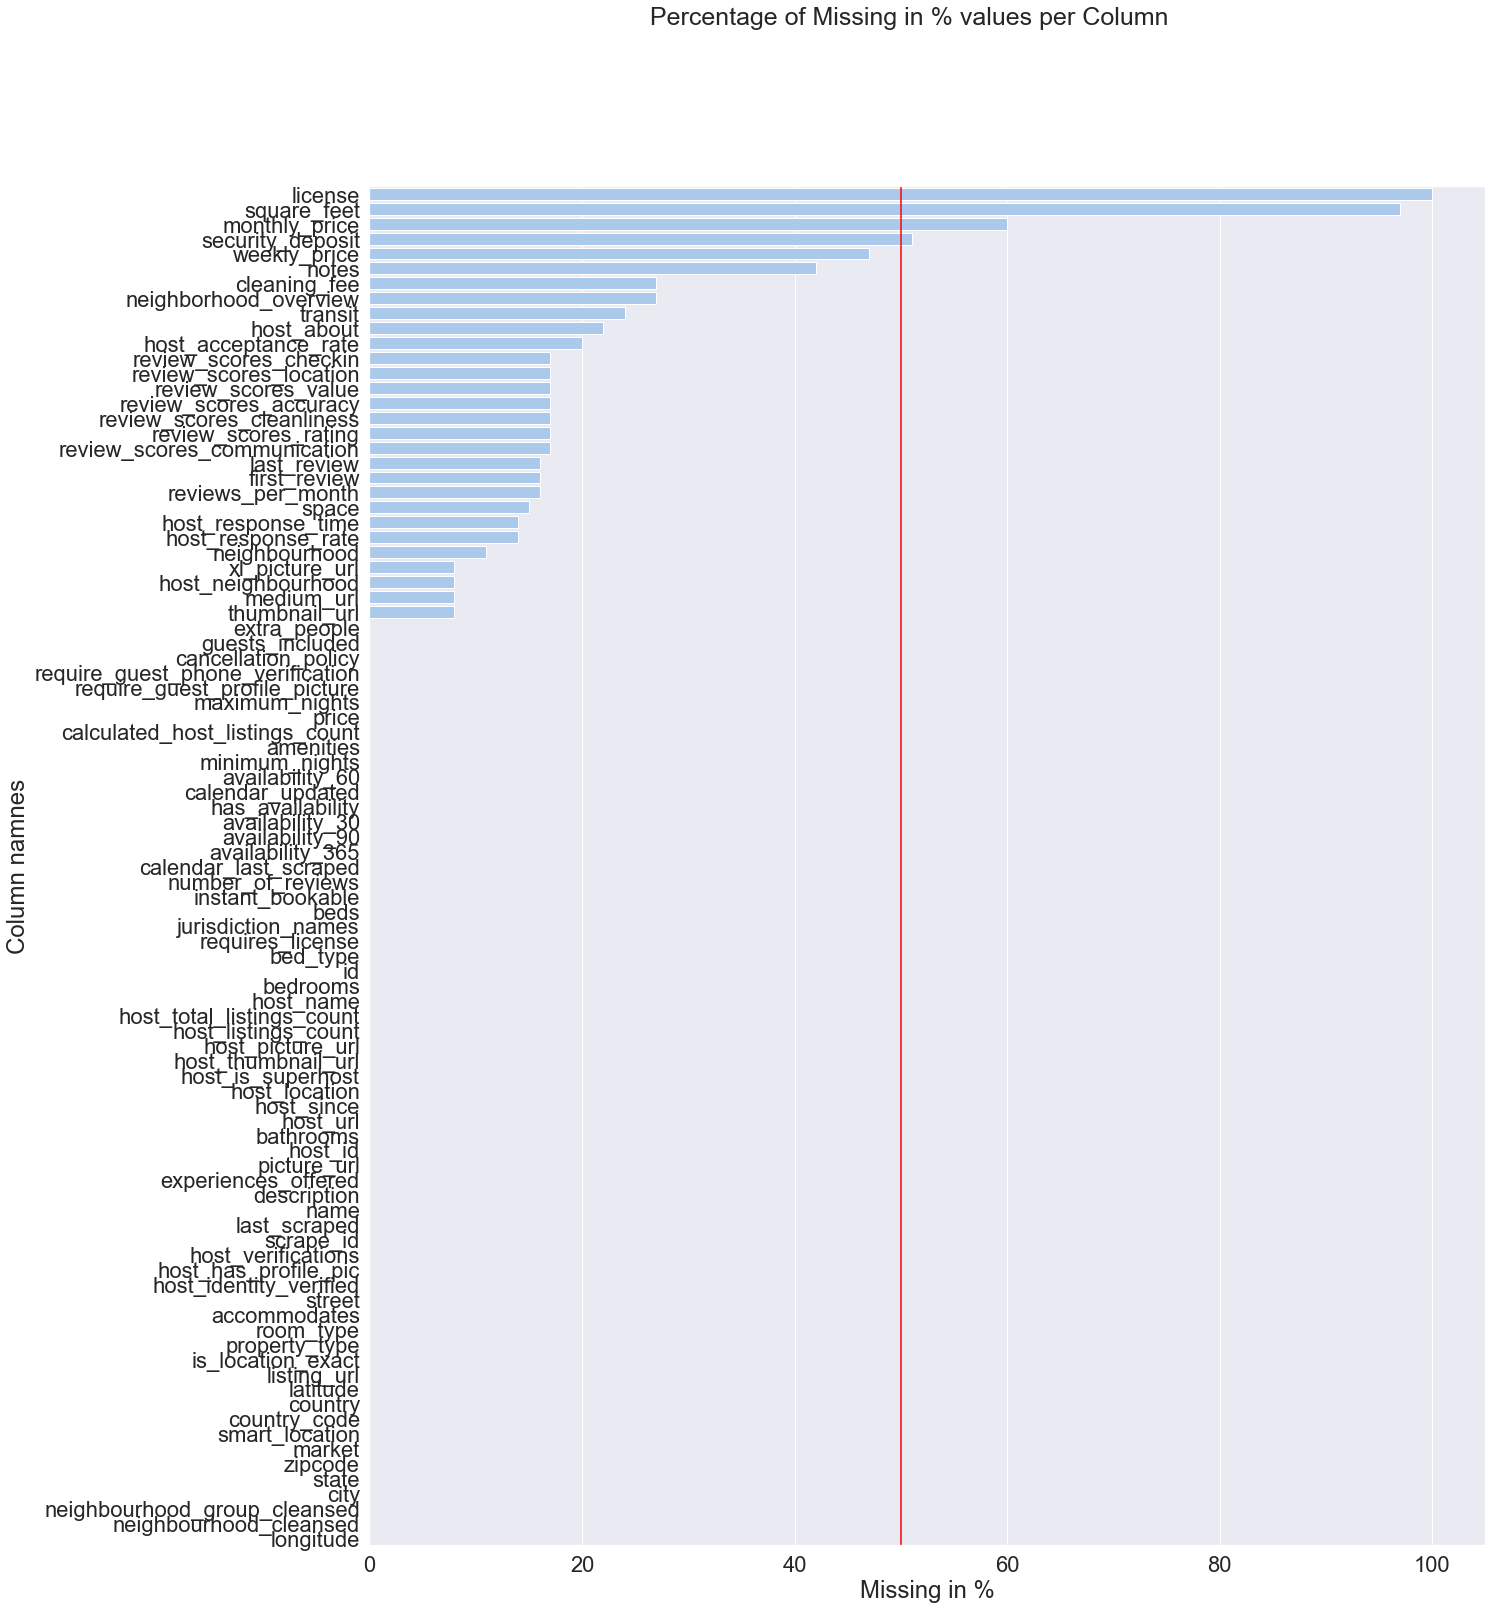

In [13]:
# The plot shows the amount of Missing values in % 
cl=plot_data(df_info,'Missing in %')

Enter max. threshold 100
Enter min. threshold 20


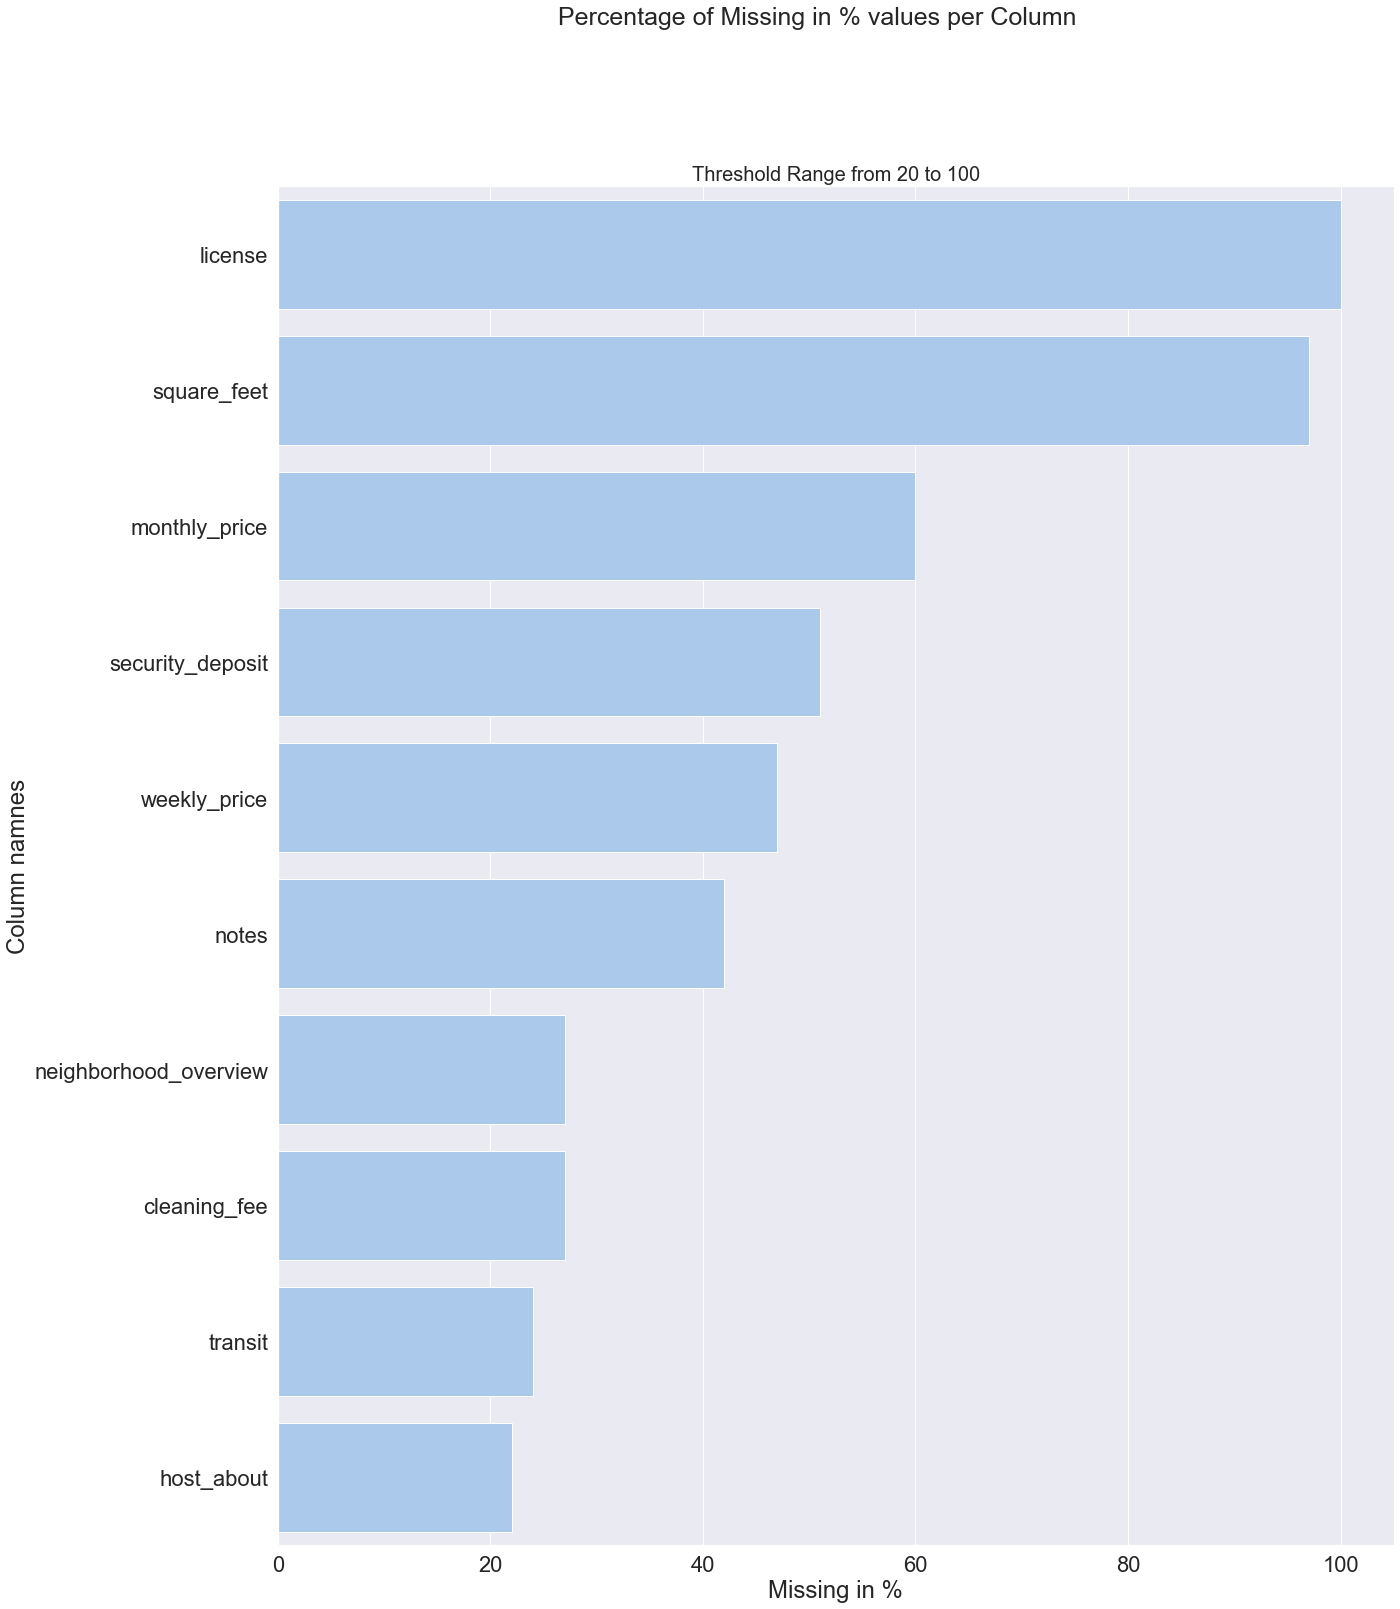

In [16]:
# Reducing on columns with Missings
cl=plot_data(df_info,'Missing in %',True)

In [29]:
# Inspecting columns with Missing values
df[np.intersect1d(df.columns,cl)].head(5)

,cleaning_fee,host_about,license,monthly_price,neighborhood_overview,notes,security_deposit,square_feet,transit,weekly_price
0,NaN,"I am an artist, interior designer, and run a s...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,$40.00,Living east coast/left coast/overseas. Time i...,NaN,"$3,000.00","Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,$100.00,NaN,"Convenient bus stops are just down the block, ...","$1,000.00"
2,$300.00,i love living in Seattle. i grew up in the mi...,NaN,NaN,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,"$1,000.00",NaN,A bus stop is just 2 blocks away. Easy bus a...,NaN
3,NaN,NaN,NaN,"$2,300.00",NaN,NaN,NaN,NaN,NaN,$650.00
4,$125.00,"Hi, I live in Seattle, Washington but I'm orig...",NaN,NaN,We are in the beautiful neighborhood of Queen ...,Belltown,$700.00,NaN,The nearest public transit bus (D Line) is 2 b...,NaN


Enter max. threshold 50
Enter min. threshold 0


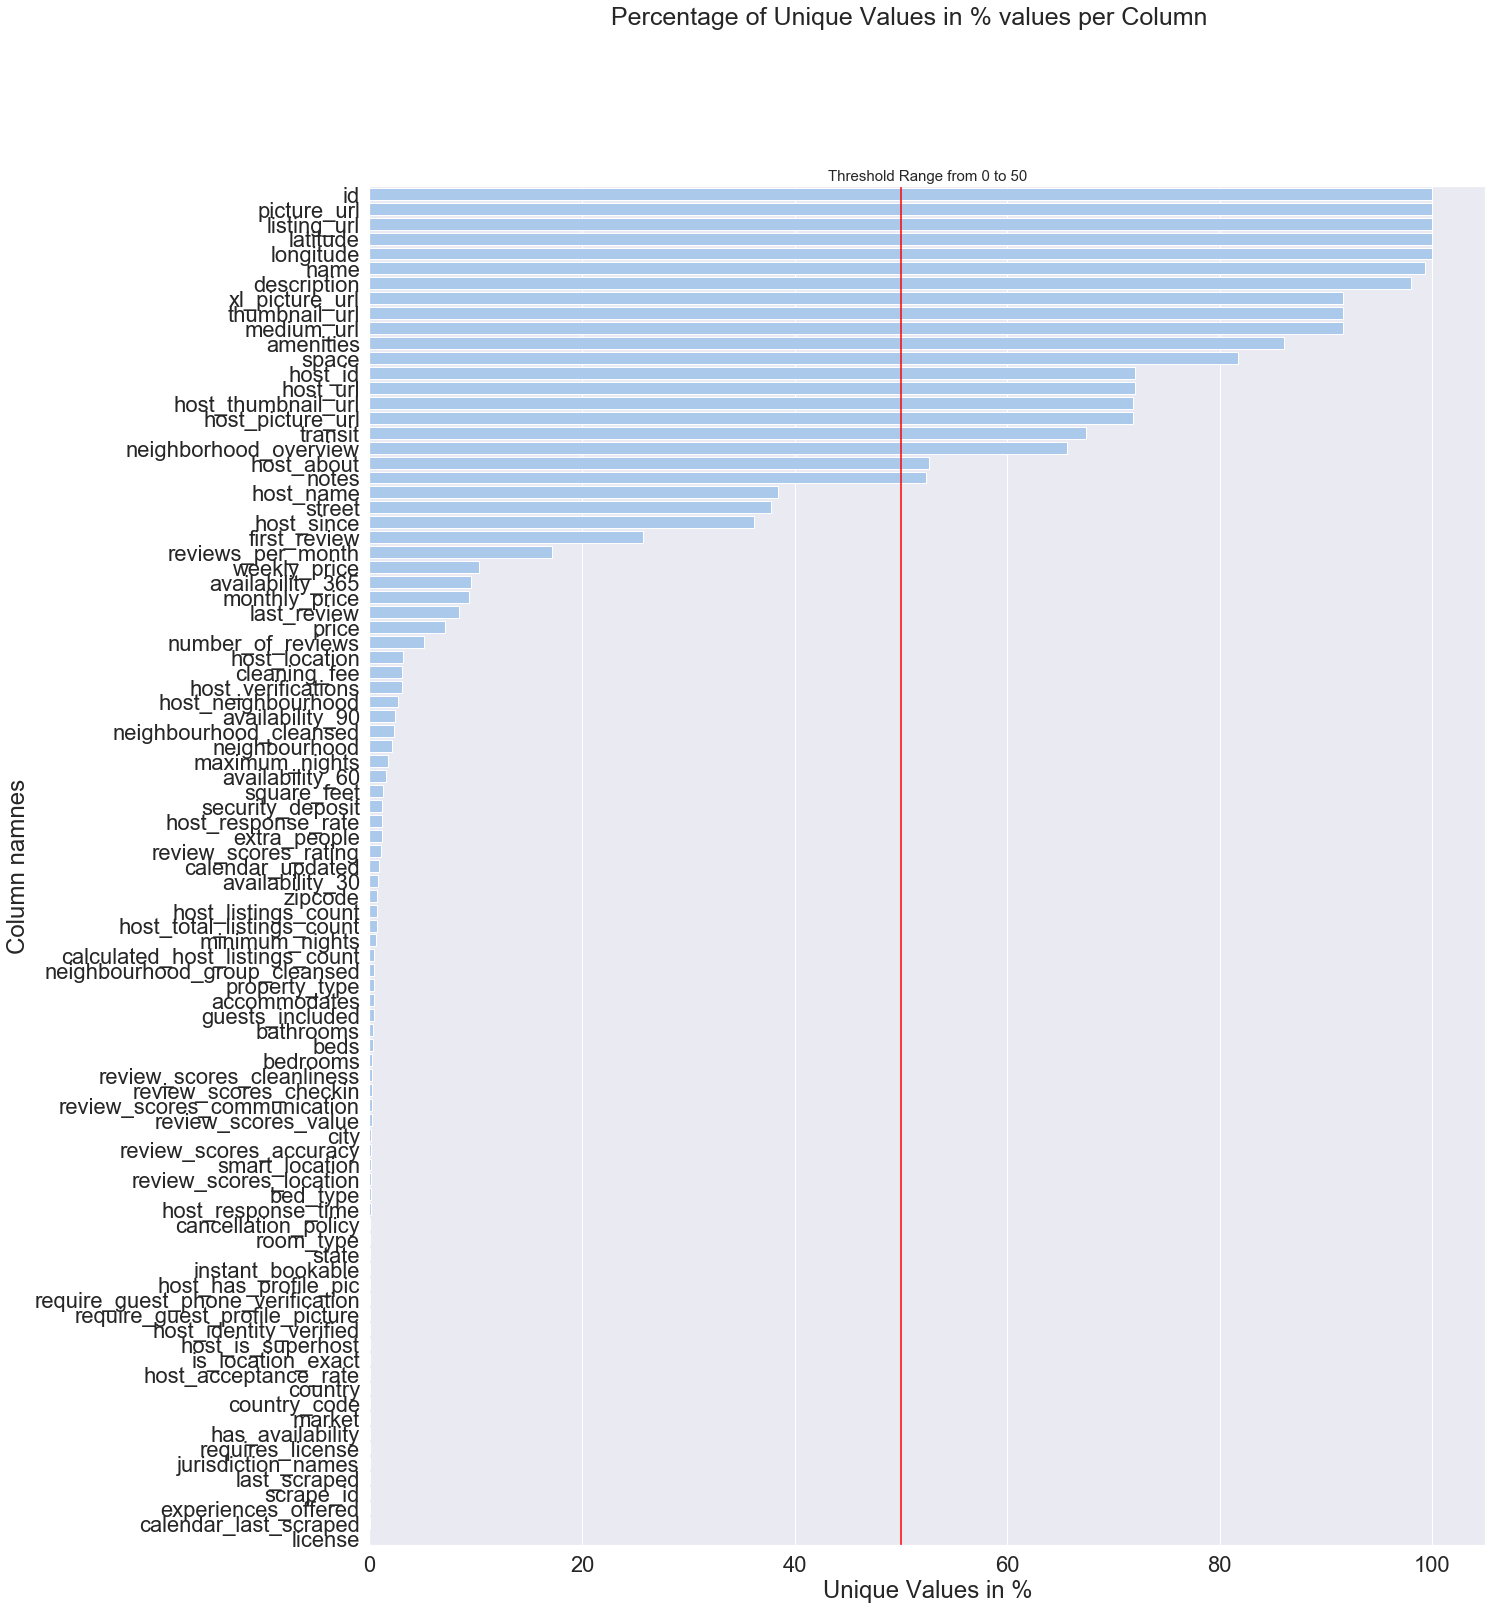

In [212]:
# Plotting the percentage of unique values per column
plot_data(df_info,'Unique Values in %')

Enter max. threshold 100
Enter min. threshold 20


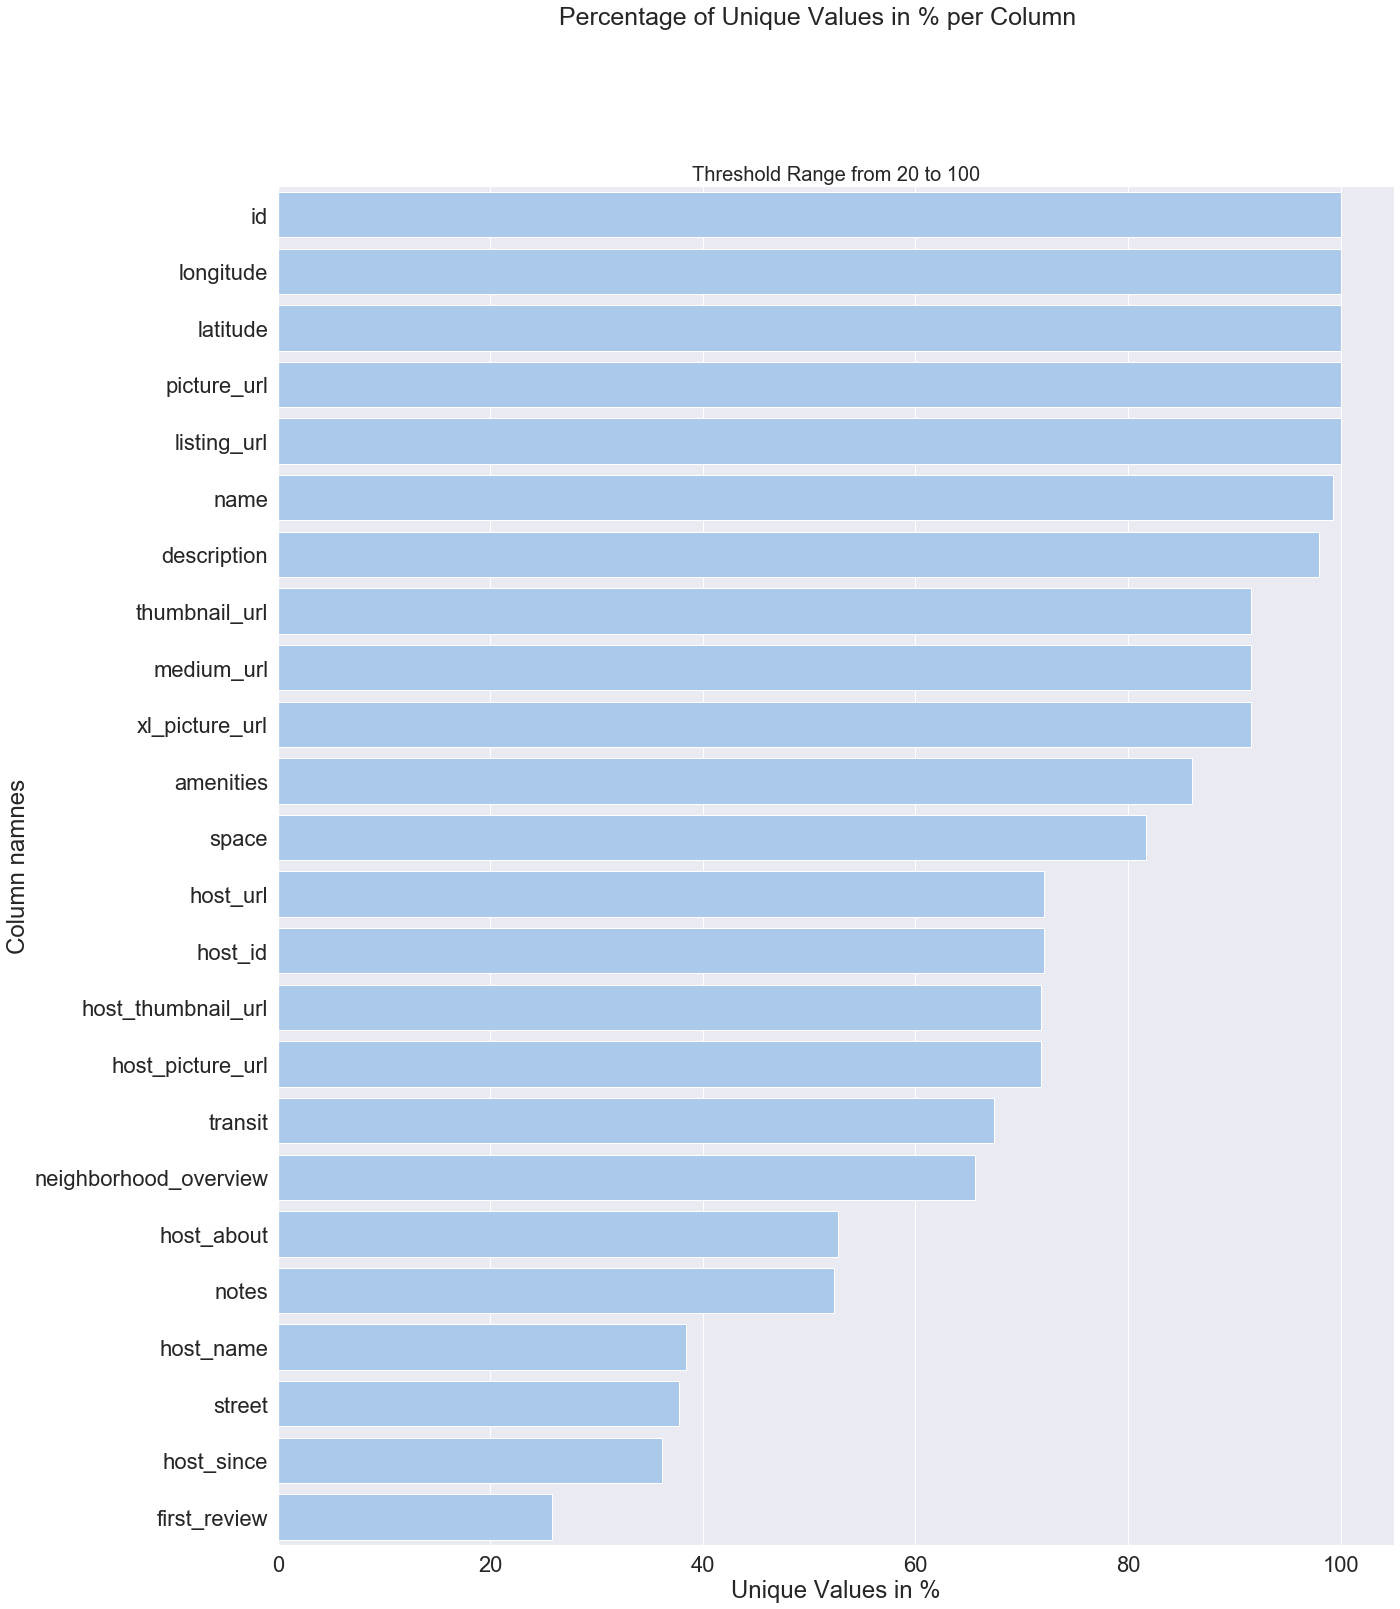

In [30]:
# Plotting columns with more than 50% unique values 
ucl=plot_data(df_info,'Unique Values in %', query=True)

In [20]:
# Inspecting the data 
df[np.intersect1d(df.columns,ucl)].head(5)

,amenities,description,host_about,host_id,host_picture_url,host_thumbnail_url,host_url,id,latitude,listing_url,longitude,medium_url,name,neighborhood_overview,notes,picture_url,space,thumbnail_url,transit,xl_picture_url
0,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",Make your self at home in this charming one-be...,"I am an artist, interior designer, and run a s...",956883,https://a0.muscache.com/ac/users/956883/profil...,https://a0.muscache.com/ac/users/956883/profil...,https://www.airbnb.com/users/show/956883,241032,47.636289,https://www.airbnb.com/rooms/241032,-122.371025,NaN,Stylish Queen Anne Apartment,NaN,NaN,https://a1.muscache.com/ac/pictures/67560560/c...,Make your self at home in this charming one-be...,NaN,NaN,NaN
1,"{TV,Internet,""Wireless Internet"",Kitchen,""Free...",Chemically sensitive? We've removed the irrita...,Living east coast/left coast/overseas. Time i...,5177328,https://a0.muscache.com/ac/users/5177328/profi...,https://a0.muscache.com/ac/users/5177328/profi...,https://www.airbnb.com/users/show/5177328,953595,47.639123,https://www.airbnb.com/rooms/953595,-122.365666,https://a0.muscache.com/im/pictures/14409893/f...,Bright & Airy Queen Anne Apartment,"Queen Anne is a wonderful, truly functional vi...",What's up with the free pillows? Our home was...,https://a0.muscache.com/ac/pictures/14409893/f...,"Beautiful, hypoallergenic apartment in an extr...",https://a0.muscache.com/ac/pictures/14409893/f...,"Convenient bus stops are just down the block, ...",https://a0.muscache.com/ac/pictures/14409893/f...
2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",New modern house built in 2013. Spectacular s...,i love living in Seattle. i grew up in the mi...,16708587,https://a1.muscache.com/ac/users/16708587/prof...,https://a1.muscache.com/ac/users/16708587/prof...,https://www.airbnb.com/users/show/16708587,3308979,47.629724,https://www.airbnb.com/rooms/3308979,-122.369483,NaN,New Modern House-Amazing water view,Upper Queen Anne is a charming neighborhood fu...,Our house is located just 5 short blocks to To...,https://a2.muscache.com/ac/pictures/b4324e0f-a...,"Our house is modern, light and fresh with a wa...",NaN,A bus stop is just 2 blocks away. Easy bus a...,NaN
3,"{Internet,""Wireless Internet"",Kitchen,""Indoor ...",A charming apartment that sits atop Queen Anne...,NaN,9851441,https://a2.muscache.com/ac/users/9851441/profi...,https://a2.muscache.com/ac/users/9851441/profi...,https://www.airbnb.com/users/show/9851441,7421966,47.638473,https://www.airbnb.com/rooms/7421966,-122.369279,NaN,Queen Anne Chateau,NaN,NaN,https://a0.muscache.com/ac/pictures/94146944/6...,NaN,NaN,NaN,NaN
4,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",Cozy family craftman house in beautiful neighb...,"Hi, I live in Seattle, Washington but I'm orig...",1452570,https://a0.muscache.com/ac/users/1452570/profi...,https://a0.muscache.com/ac/users/1452570/profi...,https://www.airbnb.com/users/show/1452570,278830,47.632918,https://www.airbnb.com/rooms/278830,-122.372471,NaN,Charming craftsman 3 bdm house,We are in the beautiful neighborhood of Queen ...,Belltown,https://a1.muscache.com/ac/pictures/6120468/b0...,Cozy family craftman house in beautiful neighb...,NaN,The nearest public transit bus (D Line) is 2 b...,NaN


In [31]:
df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_id', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_listings_count', 'host_total_listings_count',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', '

There are a lot of columns with to many Missing values (e.g license, security_deposit), columns with two many unique values (mainly additional id-columns e.g scrape_id) or of little unique values (e.g has availability,calendar_last_scraped), redundant informatioen (e.g state,country), descritptions (e.g. description, notes, transit), url's to pictures etc.! Those columms will get dropped with the next step. 

In [13]:
# Defining col -list for deletion
del_col='license','square_feet','monthly price', 'security_deposit', 'weekly price', 'notes', \
'first_review','host_about','medium_url','thumbnail url', 'transit', \
'xl_picture_url','host_picture_url','host_thumbnail_url','host_url','medium_url','street',\
'thumbnail_url', 'space', 'name','street','listing_url','longitude','latitude','picture_url',\
'neighborhood_overview','transit','scrape_id','last_scraped','summary','description',\
'market','country_code','has_availability','requires_license',\
'jurisdiction_names','host_name','experiences_offered','host_neighbourhood','city',\
'state','smart_location','country','weekly_price','monthly_price','calendar_last_scraped',\
'maximum_nights','calendar_updated','has_availability','availability_30','availability_60',\
'availability_90','availability_365','zipcode','is_location_exact','neighbourhood',\
'host_listings_count', 'host_total_listings_count','host_listings_count', \
'host_total_listings_count'

In [14]:
# drop columns
df_fin=df[df.columns[~df.columns.isin(del_col)]]

#### Host- and Objectanalysis 

After analyzing the meta values of the columns, I want to investigate how the distribution of the missing values is on object level and whether this is dependent on the host (e.g. carelessness in information provision).
For this I will create a multiplot to make it easy to interpret.

C:\Users\ashra\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\ashra\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Top 5 Hosts with Missing values per Object')

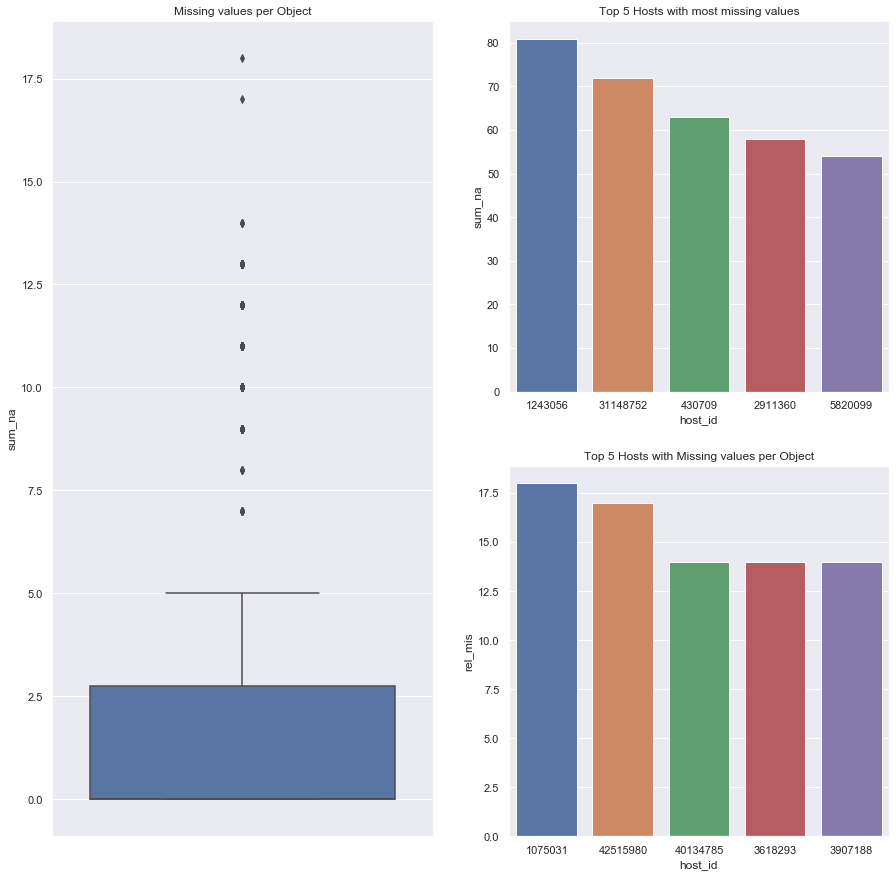

In [15]:
#Sum Missing values per row/ id
df_fin['sum_na']=df_fin.isna().sum(axis=1)
#Missing values 
df_grp=pd.DataFrame(df_fin.groupby('host_id')['sum_na'].sum().\
                        reset_index().sort_values('sum_na',ascending=False)).head(5)

#Inspecting host with most missing values per Object
df_fin['id_host']=df_fin['host_id']
df_grp_rel=pd.DataFrame(df_fin.groupby('host_id').agg({'sum_na':'sum','id_host':'count'}).reset_index())
df_grp_rel['rel_mis']=(df_grp_rel['sum_na']/df_grp_rel['id_host'])
rel_5=df_grp_rel.sort_values('rel_mis',ascending=False).head(5)

# Defining plot order 
plt_order=df_grp.host_id.values
plt_order_rel=rel_5.host_id.values

# Creating multiplot 
sns.set(font_scale = 1)
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 2,1)
sns.boxplot(x='sum_na',data=df_fin,orient="v")
plt.title('Missing values per Object', size=12)
ax = fig.add_subplot(2, 2,2)
sns.barplot(x='host_id',y='sum_na',data=df_grp, order=plt_order)
plt.title('Top 5 Hosts with most missing values', size=12)
ax = fig.add_subplot(2, 2,4)
sns.set_color_codes("pastel")
sns.barplot(x="host_id", y="rel_mis", data=rel_5,order=plt_order_rel)
plt.title('Top 5 Hosts with Missing values per Object', size=12)

The box plot shows the distribution of missing values for each rental property; it is noticeable that there are some outliers. 
The upper bar chart shows the sum of all missing values per host, but the lower bar chart is more pertinent, as the missing values are put in relation to the number of rental objects. 
A closer look at these hosts shows that they belong to the outliers of the box plot (lower section). 
Host "1075031" and "42515980" cross the 40%-mark of missing values, thus both objects will be dropped. 

In [16]:
# Calculating the percentage of missing values in relation to the shape of the set 
df_fin['na/shape']=round((df_fin['sum_na']/df_fin.shape[1])*100)
# Extracting hosts 
host_list=rel_5['host_id'].to_list()
host_list
df_fin.query("host_id==@host_list")

C:\Users\ashra\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,...,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,sum_na,id_host,na/shape
1297,8354452,42515980,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,...,NaN,f,moderate,f,f,1,NaN,17,42515980,40.0
1419,10235014,1075031,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,...,NaN,f,flexible,f,f,1,NaN,18,1075031,42.0
2597,8356608,40134785,2015-07-31,NaN,NaN,NaN,NaN,f,['phone'],t,...,NaN,f,flexible,f,f,1,NaN,14,40134785,33.0
2717,745099,3907188,2012-10-18,"Seattle, Washington, United States",NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,...,NaN,f,flexible,f,f,1,NaN,14,3907188,33.0
3337,704477,3618293,2012-09-19,"Seattle, Washington, United States",NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'kba']",t,...,NaN,f,flexible,f,f,1,NaN,14,3618293,33.0


In [17]:
# Dropping both hosts 
df_fin=df_fin.query("host_id!=1075031 or host_id!=42515980")

#### Inactive Listings 

In order to have an accurat analysis, i am going to check if there are inactive listings. 

In [18]:
# checking for inactive listings 
df_fin['last_rev']=pd.DatetimeIndex(df_fin['last_review']).year
# There are some, which last review is from 2013 and older 
df_fin['last_rev'].value_counts()

2015.0    2894
2016.0     217
2014.0      61
2013.0      12
2012.0       6
2011.0       1
Name: last_rev, dtype: int64

In [19]:
# Inspecting those cases 
df_fin.query("last_rev<2014")

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,...,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,sum_na,id_host,na/shape,last_rev
212,781474,4122018,2012-11-11,"Seattle, Washington, United States",within an hour,100%,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,...,f,moderate,t,t,2,0.03,2,4122018,5.0,2013.0
479,610989,3029318,2012-07-23,"Seattle, Washington, United States",NaN,NaN,NaN,f,"['email', 'phone', 'reviews', 'kba']",t,...,f,strict,f,f,1,0.04,4,3029318,9.0,2013.0
482,186328,895223,2011-07-30,"Seattle, Washington, United States",NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'linkedin', 're...",t,...,f,strict,f,f,1,0.04,10,895223,23.0,2013.0
505,1343805,3939559,2012-10-21,"Seattle, Washington, United States",NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,...,f,flexible,f,f,1,0.04,3,3939559,7.0,2013.0
507,103920,541406,2011-04-28,"Seattle, Washington, United States",within a day,100%,100%,f,"['email', 'phone', 'reviews']",t,...,f,strict,t,t,2,0.03,0,541406,0.0,2012.0
979,319768,1577903,2012-01-07,"Seattle, Washington, United States",within an hour,100%,NaN,f,"['email', 'phone', 'facebook', 'linkedin', 're...",t,...,f,moderate,f,f,1,0.11,1,1577903,2.0,2013.0
1151,48319,220013,2010-09-01,"Seattle, Washington, United States",NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'linkedin', 're...",t,...,f,strict,t,t,1,0.38,3,220013,7.0,2012.0
1495,607788,103427,2010-04-04,"West Hollywood, California, United States",within a day,87%,100%,f,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,...,f,strict,f,f,2,0.05,0,103427,0.0,2013.0
1521,1251813,661691,2011-06-03,"Vancouver, Washington, United States",within a few hours,92%,100%,f,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,...,f,strict,f,f,4,0.04,0,661691,0.0,2013.0
1786,233502,1215564,2011-09-27,"Seattle, Washington, United States",NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'reviews']",t,...,f,flexible,f,f,1,0.02,3,1215564,7.0,2012.0


It is difficult to judge, but all of those have very low reviews per month. Since I want to make sure that I only look at active listing, i am going to drop all listing, which were last reviewd in 2011,2012,2013. 
The dataset is from 2016, so it is very unrealistic that the offer is still active if it was last reviewd in 2011, 2012 or 2013. 

In [20]:
# Dropping years 
df_fin=df_fin.query("last_rev>=2014")

#### review_scores_rating - a product of other review_scores ? 

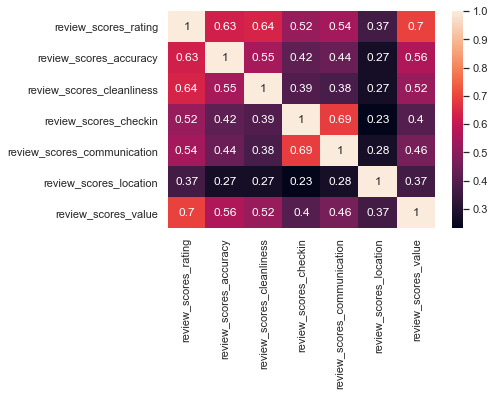

In [21]:
# I am assuming that review_scores_rating is just a product of the other scores
df_corr=df_fin[['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',\
               'review_scores_checkin','review_scores_communication','review_scores_location',\
               'review_scores_value']]
# review_scores_rating is highly correlated 
corrMat=df_corr.corr()
sns.heatmap(corrMat,annot=True)

The chart shows a strong correlation between the review_scores_rating and the other review_scores.
So I will remove this variable.

In [22]:
# Inspecting columns
df_fin.columns

Index(['id', 'host_id', 'host_since', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'amenities', 'price', 'cleaning_fee',
       'guests_included', 'extra_people', 'minimum_nights',
       'number_of_reviews', 'last_review', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month', 'sum_na', 'id_host', 'na/shape', 'last_rev'],
      dtype='object'

In [23]:
#Dropping unnecessary columns
df_fin.drop(['last_rev','last_review','review_scores_rating','sum_na','id_host',\
            'na/shape'],axis=1,inplace=True)

### Feature Engineering 

#### Amenities

In [24]:
# Inspecting the amenities
df_fin['amenities']

0       {TV,"Cable TV",Internet,"Wireless Internet","A...
1       {TV,Internet,"Wireless Internet",Kitchen,"Free...
2       {TV,"Cable TV",Internet,"Wireless Internet","A...
4       {TV,"Cable TV",Internet,"Wireless Internet",Ki...
5       {"Wireless Internet","Free Parking on Premises...
                              ...                        
3810    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
3811    {TV,"Cable TV",Internet,"Wireless Internet","A...
3812    {Internet,"Wireless Internet",Kitchen,"Free Pa...
3813    {TV,"Cable TV",Internet,"Wireless Internet","A...
3814    {TV,"Cable TV",Internet,"Wireless Internet",Ki...
Name: amenities, Length: 3172, dtype: object

The amenities show that it is possible to group them in order to make a better statement about the furnishing of the object. 

In [25]:
# Safety Copy
df_clean=df_fin.copy()

## Creating new features 
# copy of amenities 
df_clean['am_c']=df_clean['amenities']
# Extracting amenities
am=[]
for index, row in df_clean.iterrows():
    am_list = row['amenities'].split(',')
    for l in am_list:
        am.append(l)

# Data-set for amenity-count
df_am=pd.DataFrame(am)
# Cleaning rows from character
df_am[0]=df_am[0].apply(lambda x: x.replace('"',''))
df_am[0]=df_am[0].apply(lambda x: x.replace('{',''))
df_am[0]=df_am[0].apply(lambda x: x.replace('}',''))

# creating a dataset 
df_am_count=pd.DataFrame(df_am[0].value_counts()).reset_index()
am_list=df_am_count['index'].to_list()

for c in am_list:
    df_clean[c] = df_clean['am_c'].str.contains(c,regex=True)*1

C:\Users\ashra\Anaconda3\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [26]:
# Inspecting the amenities
df_am_count

,index,0
0,Wireless Internet,3081
1,Heating,3044
2,Kitchen,2864
3,Smoke Detector,2772
4,Essentials,2736
5,Dryer,2494
6,Washer,2485
7,Internet,2383
8,Shampoo,2292
9,TV,2144


In [27]:
## Creating categories based on amenities 

# Internet
df_clean['Internet']=np.where((df_clean['Wireless Internet']==1) | (df_clean['Internet']==1)\
                             ,1,0)
# Protection
df_clean['Protection']=np.where((df_clean['Smoke Detector']==1)|\
                                (df_clean['Carbon Monoxide Detector']==1)|\
                                (df_clean['Fire Extinguisher']==1)|\
                                (df_clean['First Aid Kit']==1),1,0)
# Sanitary 
df_clean['Sanitary']=np.where((df_clean['Heating']==1)|\
                                            (df_clean['Air Conditioning']==1),1,0)

# Essentials
df_clean['Essential']=np.where((df_clean['Essentials']==1)|\
                              (df_clean['Shampoo']==1),1,0)
# Home items
df_clean['Home_items']=np.where((df_clean['Dryer']==1)|\
                                    (df_clean['Washer']==1)|\
                                    (df_clean['Hair Dryer']==1)|\
                                    (df_clean['Hangers']==1)|\
                                    (df_clean['Iron']==1) |\
                                    (df_clean['Washer / Dryer']==1),1,0)
# TV 
df_clean['Television']=np.where((df_clean['TV']==1)|\
                                (df_clean['Cable TV']==1),1,0)
# Security 
df_clean['Security']=np.where((df_clean['Safety Card']==1)|\
                             (df_clean['Buzzer/Wireless Intercom']==1)|\
                             (df_clean['Doorman']==1)|\
                             (df_clean['Lock on Bedroom Door']==1),1,0)
# Pets @home  
df_clean['Pets']=np.where((df_clean['Pets live on this property']==1)|\
                         (df_clean['Dog(s)']==1)|\
                         (df_clean['Cat(s)']==1)|\
                         (df_clean['Other pet(s)']==1),1,0)
# luxury interior
df_clean['Lxury_interior']=np.where((df_clean['Indoor Fireplace']==1)|\
                                   (df_clean['Hot Tub']==1)|\
                                   (df_clean['Pool']==1)|\
                                    (df_clean['Gym']==1),1,0)

In [28]:
# dropping columns
df_red=df_clean.copy()
df_red.drop(['Wireless Internet','Smoke Detector','Carbon Monoxide Detector',\
               'Fire Extinguisher','First Aid Kit','Heating','Air Conditioning',\
               'Essentials','Shampoo','Dryer','Washer','Hair Dryer','Hangers','Iron',\
               'Washer / Dryer','TV','Cable TV','Safety Card','Buzzer/Wireless Intercom',\
               'Doorman','Lock on Bedroom Door','Pets live on this property',\
               'Dog(s)','Cat(s)','Other pet(s)','Indoor Fireplace','Hot Tub','Pool',\
               'Gym','','am_c','amenities'],\
                axis=1,inplace=True)

In [29]:
# Summing up all amenities 
df_red['amenities_sum']=df_red.loc[:,'Kitchen':'Lxury_interior'].sum(axis=1)

In [30]:
df_red.head()

,id,host_id,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,...,Smoking Allowed,Protection,Sanitary,Essential,Home_items,Television,Security,Pets,Lxury_interior,amenities_sum
0,241032,956883,2011-08-11,"Seattle, Washington, United States",within a few hours,96%,100%,f,"['email', 'phone', 'reviews', 'kba']",t,...,0,0,1,0,1,1,0,0,0,6
1,953595,5177328,2013-02-21,"Seattle, Washington, United States",within an hour,98%,100%,t,"['email', 'phone', 'facebook', 'linkedin', 're...",t,...,0,1,1,1,1,1,1,0,0,10
2,3308979,16708587,2014-06-12,"Seattle, Washington, United States",within a few hours,67%,100%,f,"['email', 'phone', 'google', 'reviews', 'jumio']",t,...,0,1,1,1,1,1,0,1,1,12
4,278830,1452570,2011-11-29,"Seattle, Washington, United States",within an hour,100%,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,...,0,1,1,1,0,1,0,0,0,7
5,5956968,326758,2010-12-25,"Seattle, Washington, United States",NaN,NaN,NaN,f,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,...,0,1,1,1,0,0,0,0,0,5


#### Years of Experience

In [31]:
# Extract year for "host_since" 
df_red['years']=pd.DatetimeIndex(df_fin['host_since']).year
# The "scraped-year" was 2016 
df_red['scrap_year']=2016
# calculate difference 
df_red['years_exp']=df_red['scrap_year']-df_red['years']
df_red['years_exp'].value_counts()

2    767
1    718
3    686
4    473
5    334
6    134
7     57
8      3
Name: years_exp, dtype: int64

In [32]:
df_red.drop(['years','scrap_year','host_since'],axis=1,inplace=True)

In [33]:
# Taking a look at all columns again; 
df_red.columns

Index(['id', 'host_id', 'host_location', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms',
       'beds', 'bed_type', 'price', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'number_of_reviews',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'instant_bookable',
       'cancellation_policy', 'require_guest_profile_picture',
       'require_guest_phone_verification', 'calculated_host_listings_count',
       'reviews_per_month', 'Kitchen', 'Internet', 'Free Parking on Premises',
       'Family/Kid Friendly', 'Elevator in Building',
       'Laptop Friendly Workspace'

In [34]:
df_red['accommodates']

0        4
1        4
2       11
4        6
5        2
        ..
3810     5
3811     3
3812     4
3813     6
3814     4
Name: accommodates, Length: 3172, dtype: int64

### Variable specific cleaning

#### Removing $-Sign 

In [36]:
df_red.dtypes

id                                    int64
host_id                               int64
host_location                        object
host_response_time                   object
host_response_rate                   object
host_acceptance_rate                 object
host_is_superhost                    object
host_verifications                   object
host_has_profile_pic                 object
host_identity_verified               object
neighbourhood_cleansed               object
neighbourhood_group_cleansed         object
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
price                                object
cleaning_fee                         object
guests_included                       int64
extra_people                    

In [37]:
# Objects 
df_red[['price','cleaning_fee','extra_people']]

,price,cleaning_fee,extra_people
0,$85.00,NaN,$5.00
1,$150.00,$40.00,$0.00
2,$975.00,$300.00,$25.00
4,$450.00,$125.00,$15.00
5,$120.00,$40.00,$30.00
...,...,...,...
3810,$154.00,$85.00,$50.00
3811,$65.00,$20.00,$0.00
3812,$95.00,NaN,$8.00
3813,$359.00,$230.00,$0.00


In [38]:
df_clean_1=remove_dollar(df_red)
df_clean_1[['price','cleaning_fee','extra_people']]

,price,cleaning_fee,extra_people
0,85.0,NaN,5.0
1,150.0,40.0,0.0
2,975.0,300.0,25.0
4,450.0,125.0,15.0
5,120.0,40.0,30.0
...,...,...,...
3810,154.0,85.0,50.0
3811,65.0,20.0,0.0
3812,95.0,NaN,8.0
3813,359.0,230.0,0.0


#### From int to string

In [39]:
df_clean_2=int_to_str(df_clean_1,['id','host_id'])
df_clean_2[['id','host_id']].dtypes

id         object
host_id    object
dtype: object

#### Numeric encoding for True/False

In [40]:
df_clean_3=remove_t_f(df_clean_2)
df_clean_3.head()

is_location_exact is not in Dataset
has_availability is not in Dataset


,id,host_id,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,...,Protection,Sanitary,Essential,Home_items,Television,Security,Pets,Lxury_interior,amenities_sum,years_exp
0,241032,956883,"Seattle, Washington, United States",within a few hours,96%,100%,0,"['email', 'phone', 'reviews', 'kba']",1,1,...,0,1,0,1,1,0,0,0,6,5
1,953595,5177328,"Seattle, Washington, United States",within an hour,98%,100%,1,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,...,1,1,1,1,1,1,0,0,10,3
2,3308979,16708587,"Seattle, Washington, United States",within a few hours,67%,100%,0,"['email', 'phone', 'google', 'reviews', 'jumio']",1,1,...,1,1,1,1,1,0,1,1,12,2
4,278830,1452570,"Seattle, Washington, United States",within an hour,100%,NaN,0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,...,1,1,1,0,1,0,0,0,7,5
5,5956968,326758,"Seattle, Washington, United States",NaN,NaN,NaN,0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,...,1,1,1,0,0,0,0,0,5,6


In [41]:
df_clean_3.dtypes

id                                   object
host_id                              object
host_location                        object
host_response_time                   object
host_response_rate                   object
host_acceptance_rate                 object
host_is_superhost                    object
host_verifications                   object
host_has_profile_pic                 object
host_identity_verified               object
neighbourhood_cleansed               object
neighbourhood_group_cleansed         object
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
price                               float64
cleaning_fee                        float64
guests_included                       int64
extra_people                    

#### Remove Percentage

In [42]:
df_clean_4=remove_percent(df_clean_3)
df_clean_4.head()

,id,host_id,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_verifications,host_has_profile_pic,host_identity_verified,...,Protection,Sanitary,Essential,Home_items,Television,Security,Pets,Lxury_interior,amenities_sum,years_exp
0,241032,956883,"Seattle, Washington, United States",within a few hours,0.96,1.0,0,"['email', 'phone', 'reviews', 'kba']",1,1,...,0,1,0,1,1,0,0,0,6,5
1,953595,5177328,"Seattle, Washington, United States",within an hour,0.98,1.0,1,"['email', 'phone', 'facebook', 'linkedin', 're...",1,1,...,1,1,1,1,1,1,0,0,10,3
2,3308979,16708587,"Seattle, Washington, United States",within a few hours,0.67,1.0,0,"['email', 'phone', 'google', 'reviews', 'jumio']",1,1,...,1,1,1,1,1,0,1,1,12,2
4,278830,1452570,"Seattle, Washington, United States",within an hour,1.00,NaN,0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,...,1,1,1,0,1,0,0,0,7,5
5,5956968,326758,"Seattle, Washington, United States",NaN,NaN,NaN,0,"['email', 'phone', 'facebook', 'reviews', 'kba']",1,1,...,1,1,1,0,0,0,0,0,5,6


## Calender data

The data set does not have to be prepared so comprehensively. For the purpose of Analysis, it would be useful to have the monthly values as columns. All entries from 2017 are from January - this makes an annual comparison difficult, so only the year 2016 is taken into account. 

In [43]:
df_cal=pd.read_csv((os.getcwd()+'\\')+'calendar.csv',sep=',')

In [44]:
# Removing dollar signs from price
df_cal=remove_dollar(df_cal)

cleaning_fee is not in Dataset
extra_people is not in Dataset


In [45]:
# Extracting month and year
df_cal['Month']=pd.DatetimeIndex(df_cal['date']).month
df_cal['Year']=pd.DatetimeIndex(df_cal['date']).year
pd.crosstab(index=df_cal['Year'], columns=df_cal['Month'])

Month,1,2,3,4,5,6,7,8,9,10,11,12
Year,,,,,,,,,,,,
2016,106904,110722,118358,114540,118358,114540,118358,118358,114540,118358,114540,118358
2017,7636,0,0,0,0,0,0,0,0,0,0,0


In [46]:
# Excluding 2017 
df_cal=df_cal[df_cal['Year']==2016]

In [47]:
# Creating monthly columns with prices
m=1
month_name='Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec'

for i in month_name:
    df_cal[i]=np.where(df_cal['Month']==m,df_cal['price'],np.nan)
    m+=1

In [48]:
# Dropping columns
df_cal.drop(['date','available','price','Month'],axis=1,inplace=True)

In [49]:
# Create Yearly dataset
df_cal_year=df_cal.groupby('Year')[month_name].mean()
df_cal_year

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2016,121.568409,124.293927,128.644488,135.097005,139.538183,147.473137,152.09415,150.656594,143.255949,137.031939,135.688738,137.251835


In [50]:
# Create listing_dataset
df_cal_list=df_cal.groupby('listing_id')[month_name].mean()
df_cal_list

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
listing_id,,,,,,,,,,,,
3335,NaN,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
4291,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000,82.000000
5682,49.800000,52.826087,53.000000,53.000000,56.640000,60.000000,60.000000,60.000000,53.133333,48.580645,48.533333,48.645161
6606,92.857143,92.758621,92.580645,93.333333,92.580645,92.666667,93.225806,92.580645,93.000000,92.903226,92.666667,93.225806
7369,85.000000,85.000000,85.000000,85.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
10332096,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000
10334184,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
10339144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Analysis

## Q1 How much does Neighbourhood effect pricing ?

In [51]:
df_fin=df_clean_4.copy()

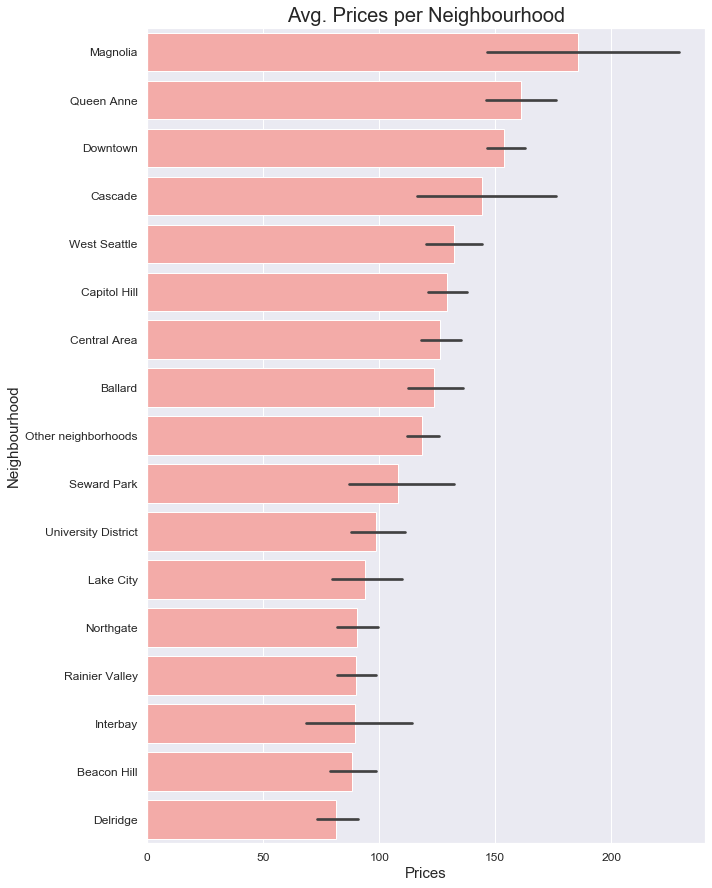

In [52]:
df_grp_hood=pd.DataFrame(df_fin.groupby("neighbourhood_group_cleansed")\
                         ['price'].mean()).sort_values('price',ascending=False).reset_index()

plt_order=df_grp_hood.neighbourhood_group_cleansed.values

sns.set(font_scale=1.0)
sns.set_color_codes("pastel")
fig=plt.figure(figsize=(10,15))

barplt=sns.barplot(x="price", y="neighbourhood_group_cleansed", data=df_fin, color="r", \
            order=plt_order)
barplt.axes.set_title("Avg. Prices per Neighbourhood", size=20)
barplt.set_xlabel("Prices",fontsize=15)
barplt.set_ylabel("Neighbourhood",fontsize=15)
barplt.tick_params(labelsize=12)
plt.show();

Depending on the district, the rent prices differ considerably. Magnolia has the highest prices, followed by Queen Ann. Clearly cheaper are objects in Delridge.

In [53]:
# Two dominant property_types 
df_fin['property_type'].value_counts()

House              1455
Apartment          1436
Townhouse            82
Condominium          68
Loft                 34
Bed & Breakfast      25
Cabin                21
Other                18
Camper/RV            10
Bungalow              9
Boat                  4
Tent                  4
Treehouse             2
Dorm                  2
Chalet                1
Yurt                  1
Name: property_type, dtype: int64

In [54]:
# Comparing prices for the Top property-types
df_ho_ap=df_fin.query("property_type=='House' or property_type=='Apartment'")
df_ho_ap_melt = pd.melt(df_ho_ap, id_vars=["neighbourhood_group_cleansed",'property_type'], value_vars="price")

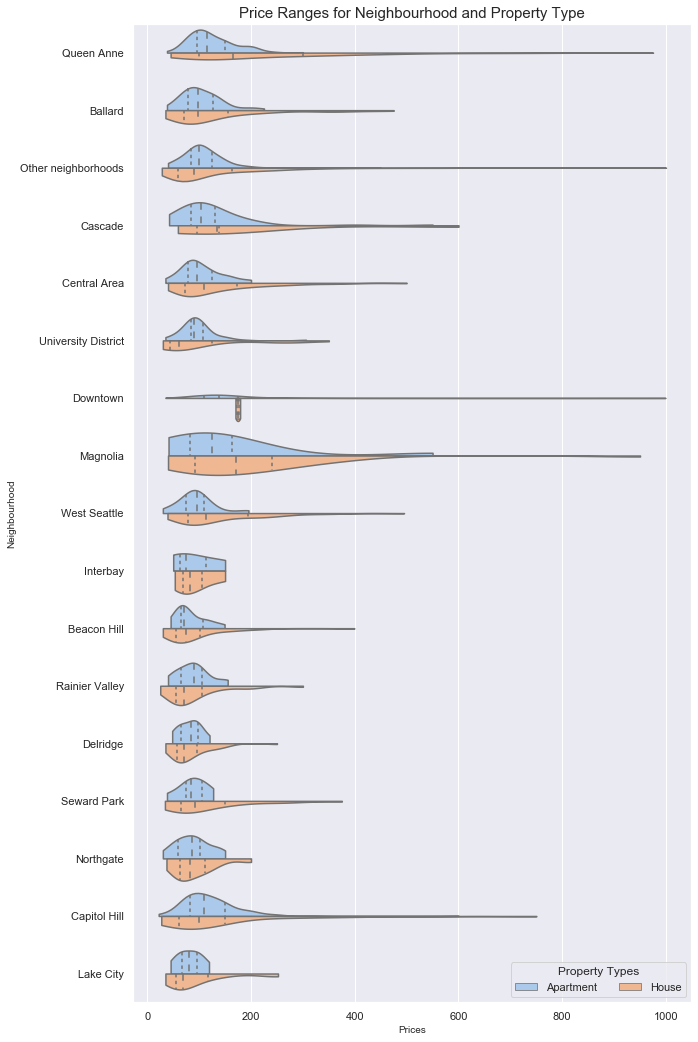

In [55]:
sns.set(font_scale=1.0)
sns.set_color_codes("pastel")
fig=plt.figure(figsize=(10,18))
vio_plt=sns.violinplot(x="price", y="neighbourhood_group_cleansed", hue="property_type",
               split=True, inner="quart", cut=0,
               palette='pastel',
               data=df_ho_ap)

vio_plt.axes.set_title("Price Ranges for Neighbourhood and Property Type", size=15)
vio_plt.axes.set_xlabel("Prices",fontsize=10)
vio_plt.axes.set_ylabel("Neighbourhood",fontsize=10)
vio_plt.axes.legend(title="Property Types",loc="lower right", ncol=3, frameon=True)
plt.show();

A comparison of prices by type of property shows that almost everywhere houses had a wider price range and were more expensive.  
Apartments are usually in a smaller price range. In Downtown the situation is different, there are only a few houses which are concentrated on a sepcific price range. 
Depending on the district, urbanity, etc., the frequency of apartments and houses is naturally different. 

So it is not only the environment that determines the price, but also the type of property. 


## Q2 Does seasonality effect pricing ? 

In [56]:
df_cal_list=df_cal_list.reset_index()
df_cal_list.rename({'listing_id':'id'},axis='columns',inplace=True)
df_cal_list['id']=df_cal_list['id'].astype(str)

In [57]:
df_fin_cal=df_fin.merge(df_cal_list, on='id',how='left')
df_fin_cal['id'].duplicated().sum()

0

In [58]:
fin_cal_melt=pd.melt(df_fin_cal,id_vars=['id','neighbourhood_group_cleansed','property_type','room_type'],value_vars=month_name)
fin_cal_melt_prop=fin_cal_melt.query("property_type=='House' or property_type=='Apartment'")

In [59]:
fin_cal_melt_prop

,id,neighbourhood_group_cleansed,property_type,room_type,variable,value
0,241032,Queen Anne,Apartment,Entire home/apt,Jan,85.000000
1,953595,Queen Anne,Apartment,Entire home/apt,Jan,125.000000
2,3308979,Queen Anne,House,Entire home/apt,Jan,975.000000
3,278830,Queen Anne,House,Entire home/apt,Jan,521.428571
4,5956968,Queen Anne,House,Private room,Jan,NaN
...,...,...,...,...,...,...
38059,262764,Other neighborhoods,House,Entire home/apt,Dec,NaN
38060,8578490,Other neighborhoods,Apartment,Entire home/apt,Dec,65.000000
38061,3383329,Other neighborhoods,Apartment,Entire home/apt,Dec,95.000000
38062,8101950,Other neighborhoods,House,Entire home/apt,Dec,NaN


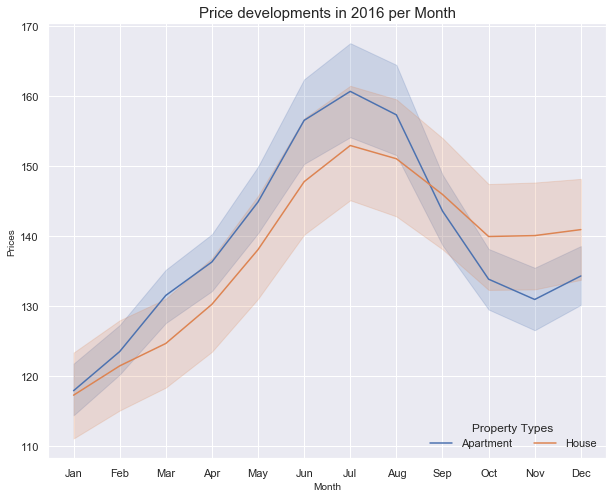

In [60]:
sns.set(font_scale=1.0)

month_order='Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec'

fig=plt.figure(figsize=(10,8))
lin_plt=sns.lineplot(x="variable", y="value",
             hue="property_type", \
             #style=fin_cal_melt[fin_cal_melt['property_type']=='House'],
             data=fin_cal_melt_prop,sort=False)
lin_plt.axes.set_title("Price developments in 2016 per Month", size=15)
lin_plt.axes.set_xlabel('Month',fontsize=10)
lin_plt.axes.set_ylabel("Prices",fontsize=10)
lin_plt.axes.legend(title="Property Types",labels=['Apartment','House'],loc="lower right", ncol=3, frameon=False)
plt.show();

The previous chart illustrates the seasonality behind the price development in the comparison of property types. 
Apartments indicate a stronger seasonality and are clearly above a house in terms of price development. 
Both types experience a peak in July and then flatten out somewhat (here apartments fall more sharply) before rising again towards the end of the year. 

## Q3 How do amenities relate to price ? 

In [61]:
## Eventuell droppen
df_fin_cal['amenities_rel']=df_fin_cal['amenities_sum']/19
df_fin_cal['amenities_rel']

0       0.315789
1       0.526316
2       0.631579
3       0.368421
4       0.263158
          ...   
3167    0.578947
3168    0.473684
3169    0.578947
3170    0.526316
3171    0.578947
Name: amenities_rel, Length: 3172, dtype: float64

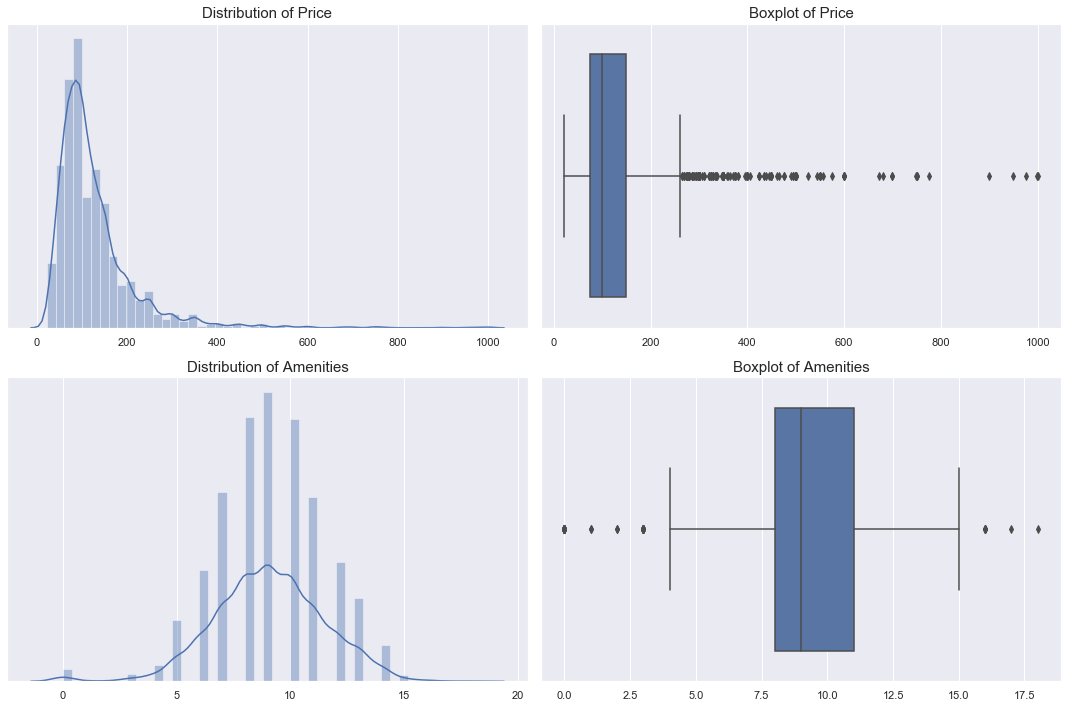

In [62]:
# Inspecting the Distriburion of price an amenities

f, axes = plt.subplots(2, 2, figsize=(15, 10), sharex=False)

x=df_fin_cal['price'].to_list()
sns.distplot(x,ax=axes[0,0])

sns.boxplot(x="price",data=df_fin_cal,ax=axes[0,1])

y=df_fin_cal['amenities_sum'].to_list()

sns.distplot(y,ax=axes[1,0])
sns.boxplot(x="amenities_sum",data=df_fin_cal,ax=axes[1,1])

axes[0][0].set_title("Distribution of Price",size=15)
axes[0][1].set_title("Boxplot of Price",size=15)
axes[0][1].set_xlabel("")
axes[1][0].set_title("Distribution of Amenities",size=15)
axes[1][1].set_title("Boxplot of Amenities",size=15)
axes[1][1].set_xlabel("")


plt.setp(axes, yticks=[])
plt.tight_layout()

The multiplot represents the distributions for the two variables - price and amenities. It is noticeable that the price is skewed. For the following bivariate analysis, I will logarithmise the price.

C:\Users\ashra\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1848: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


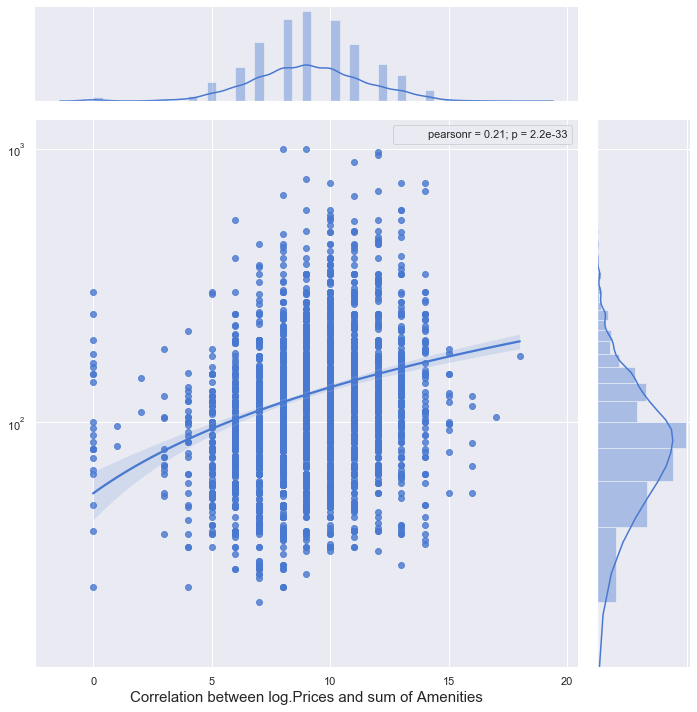

In [192]:
sns.set(font_scale=1.0)
sns.set_palette("muted")
sns.despine(fig, left=False, bottom=True)
g=sns.jointplot("amenities_sum", "price",data=df_fin_cal, height=10, kind='reg')
g.annotate(stats.pearsonr)
ax = g.ax_joint
ax.set_yscale('log')

g.set_axis_labels("Correlation between log.Prices and sum of Amenities", size=15)
g.ax_marg_y.grid('on')

The reletion between both is very small, interestingly enough the curve flattens a bit from 12 amenities on. Perhaps not all amenities are equally relevant for the price development. This is going to be analyzed in the following step.

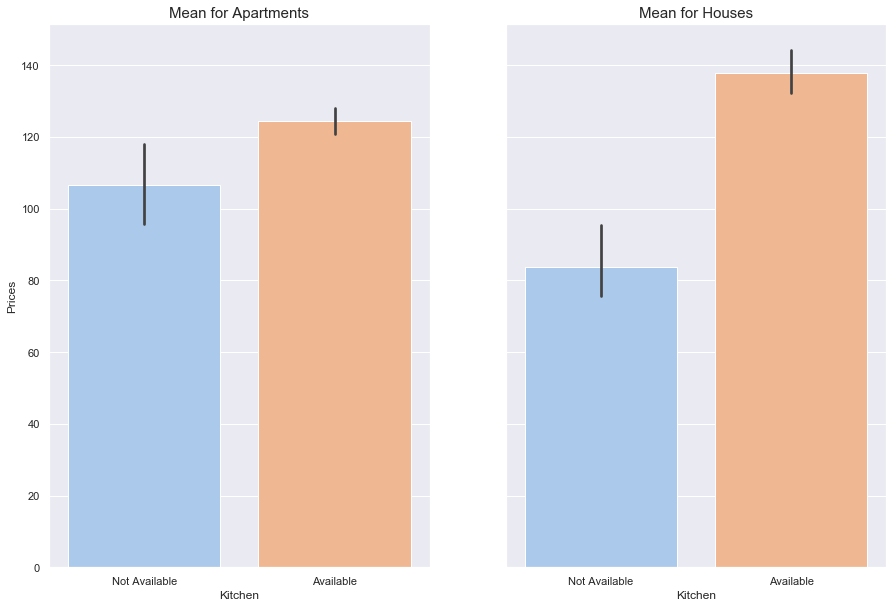

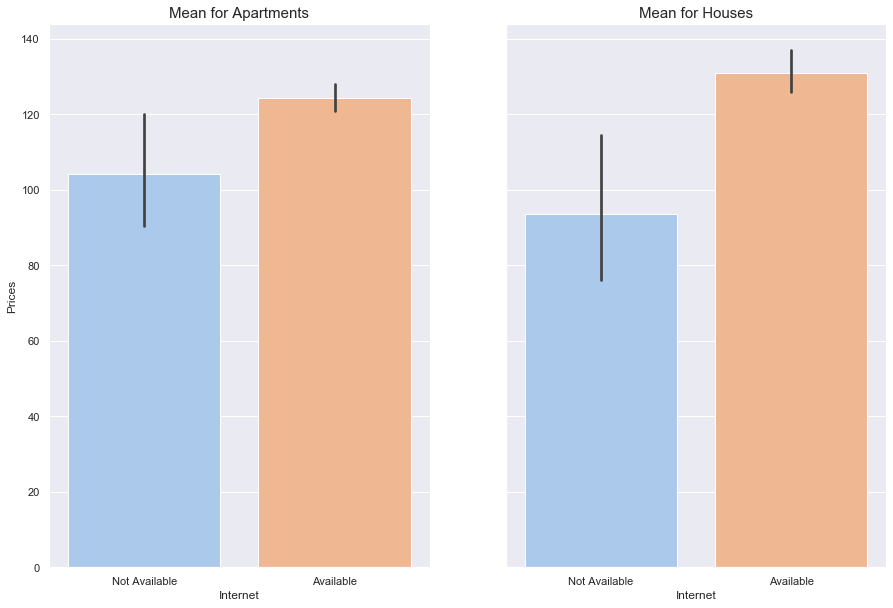

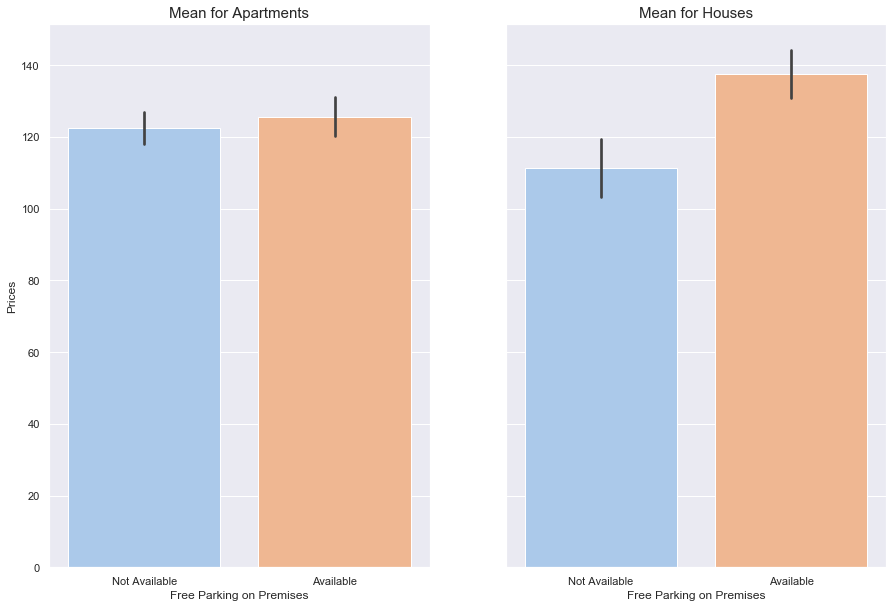

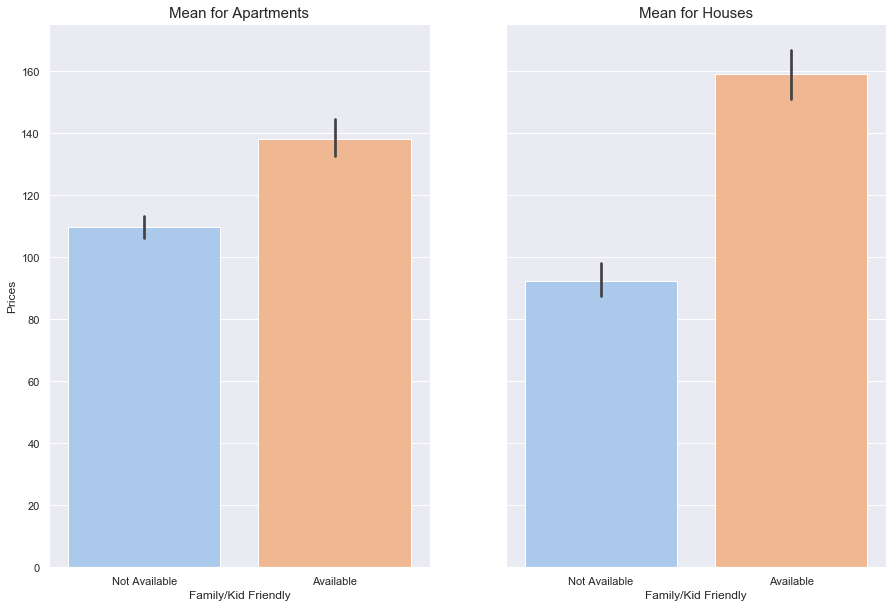

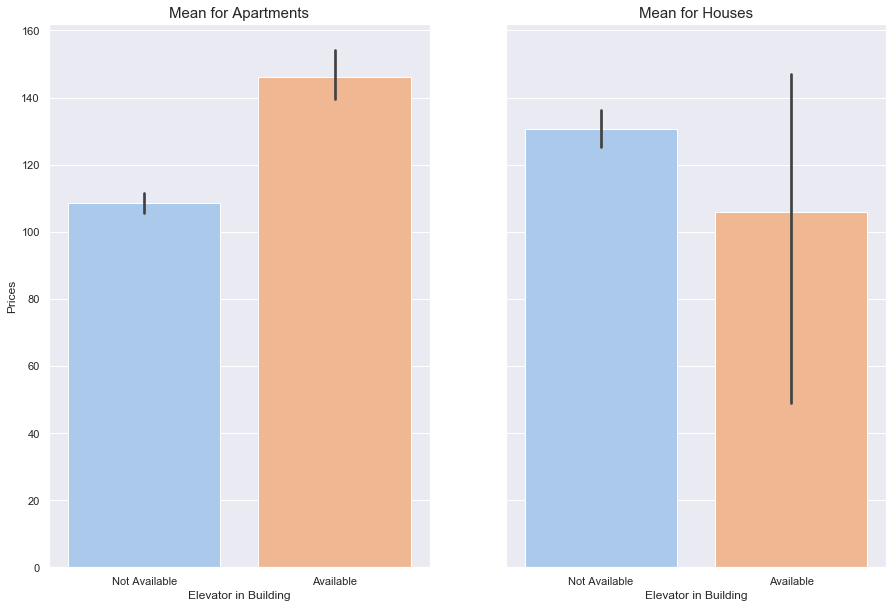

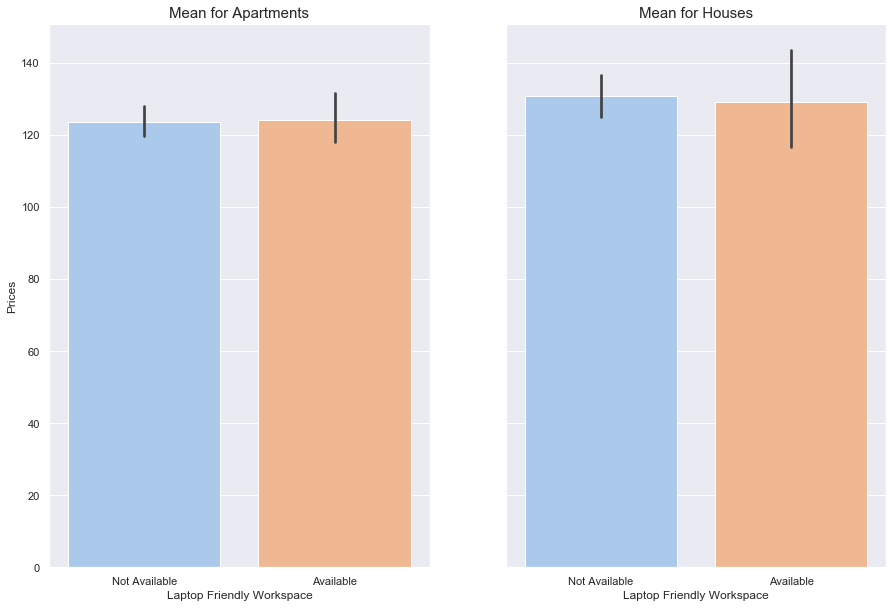

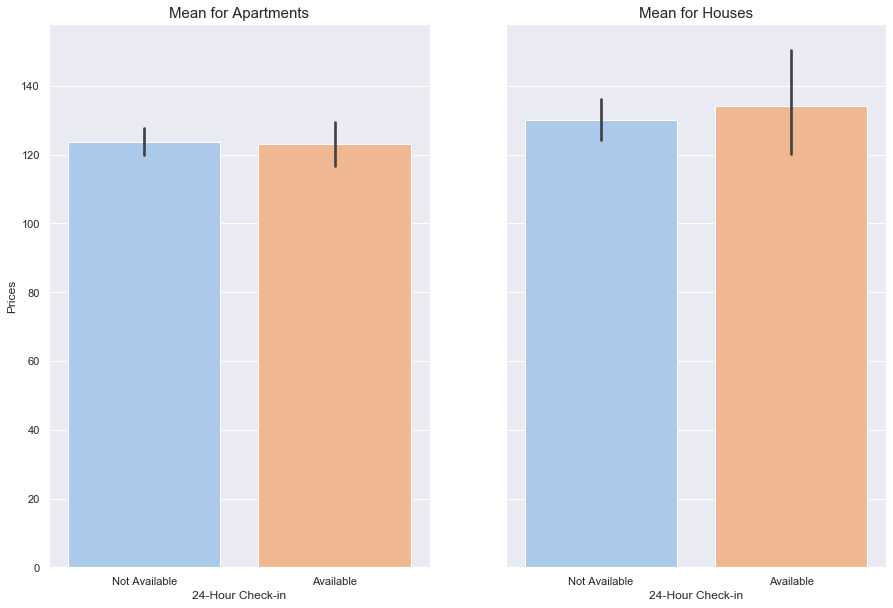

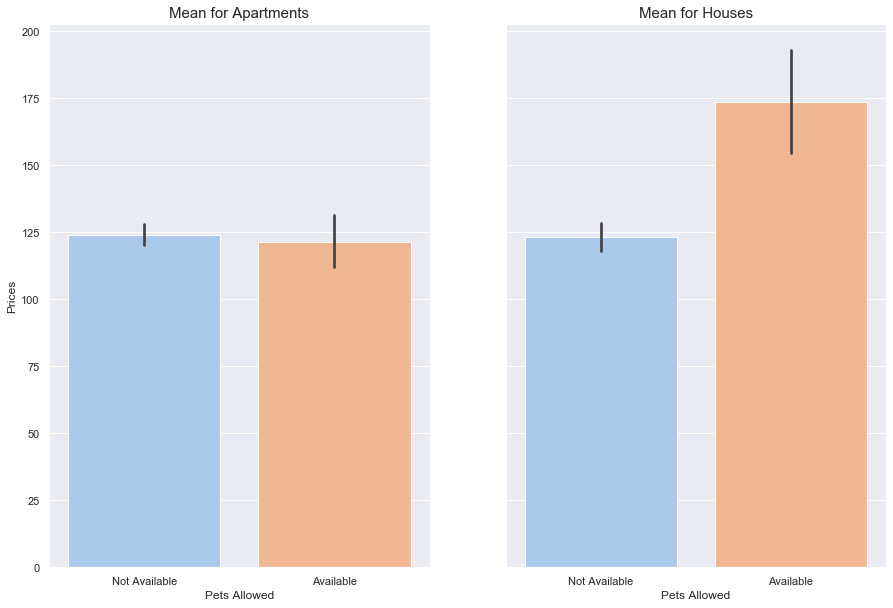

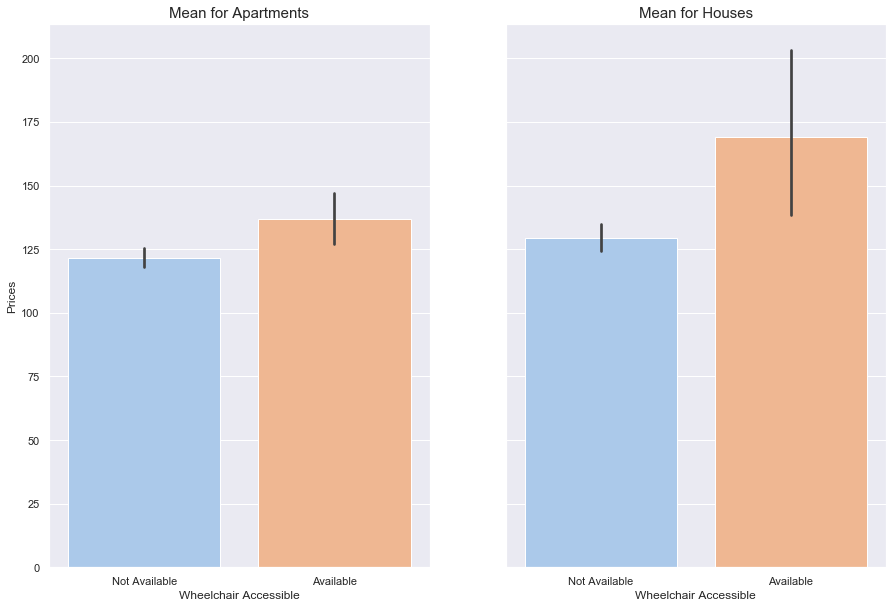

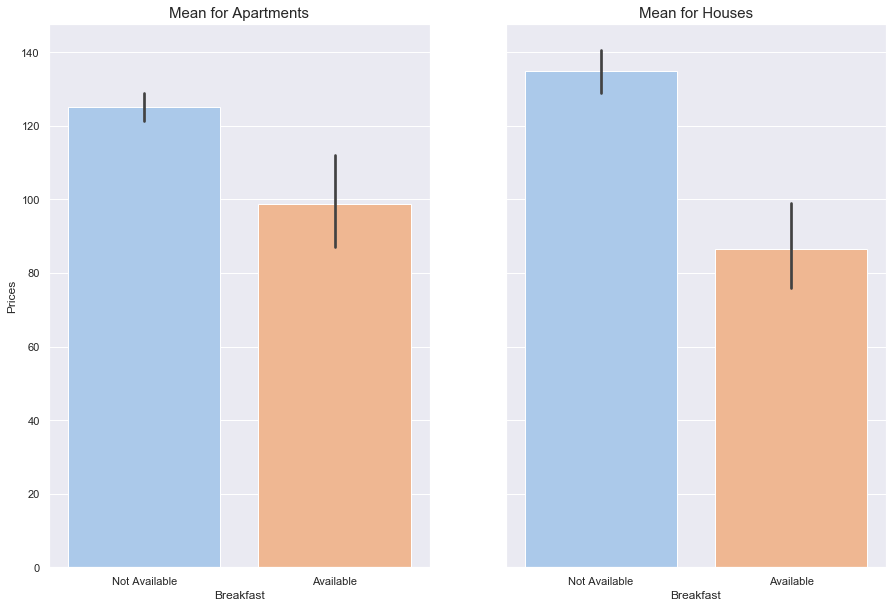

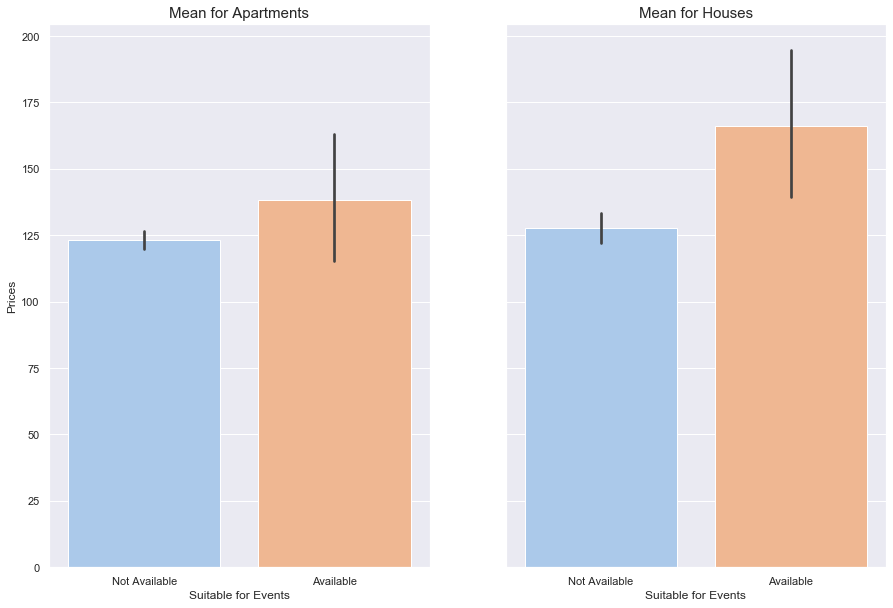

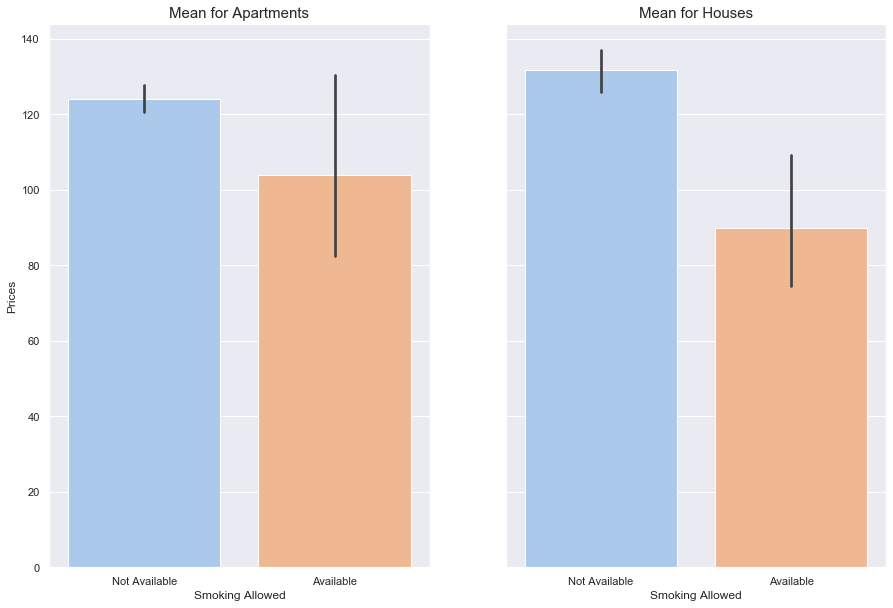

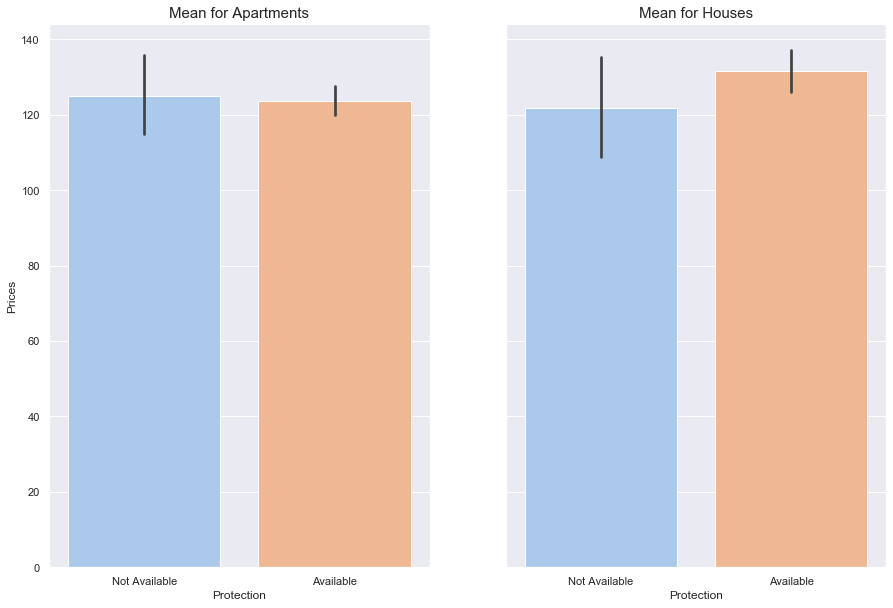

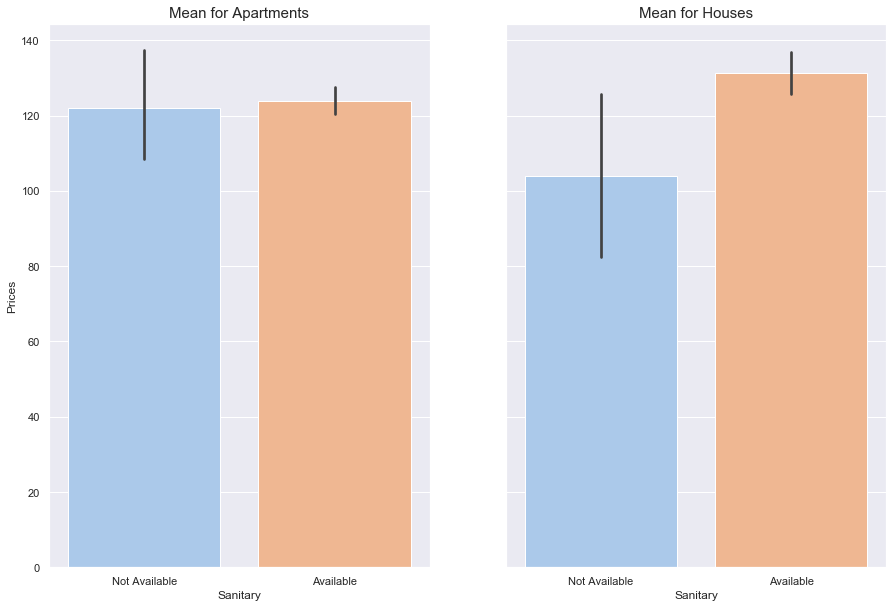

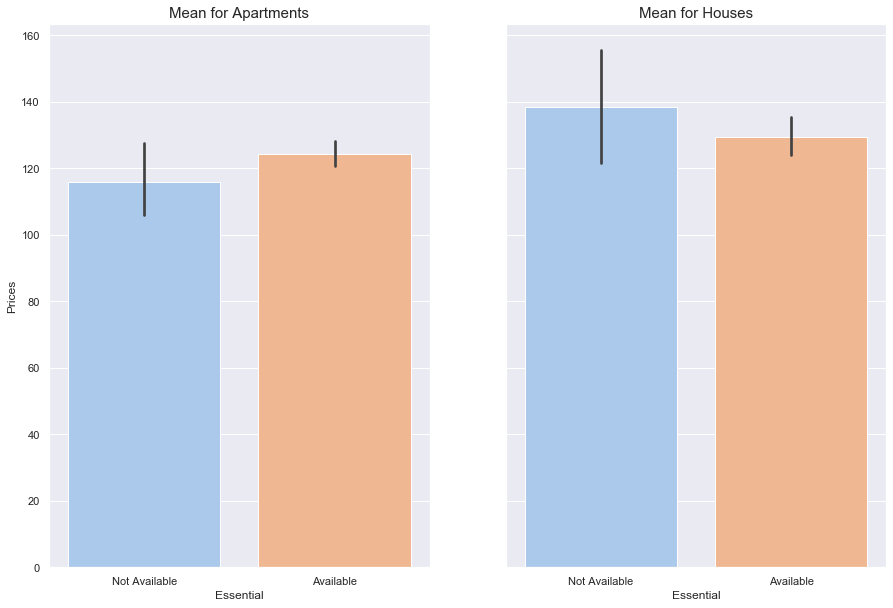

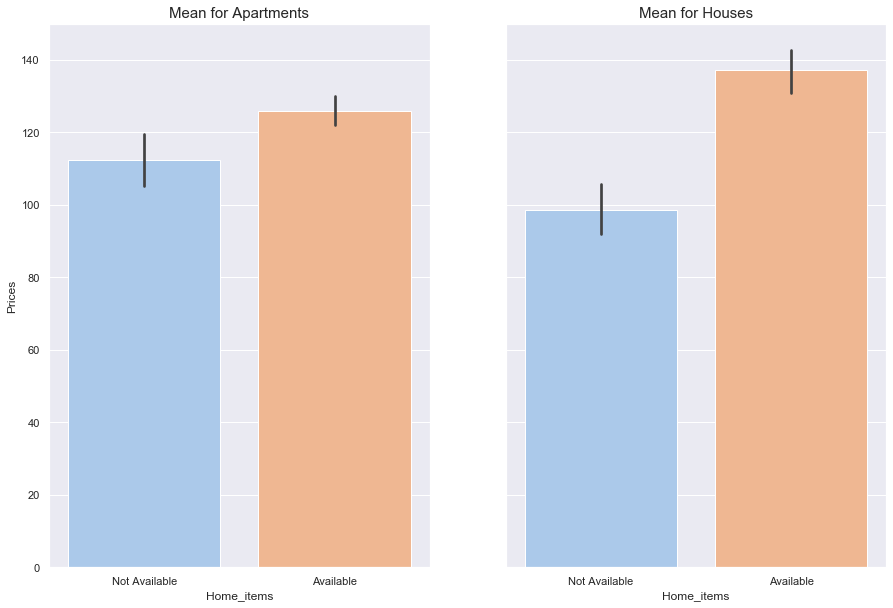

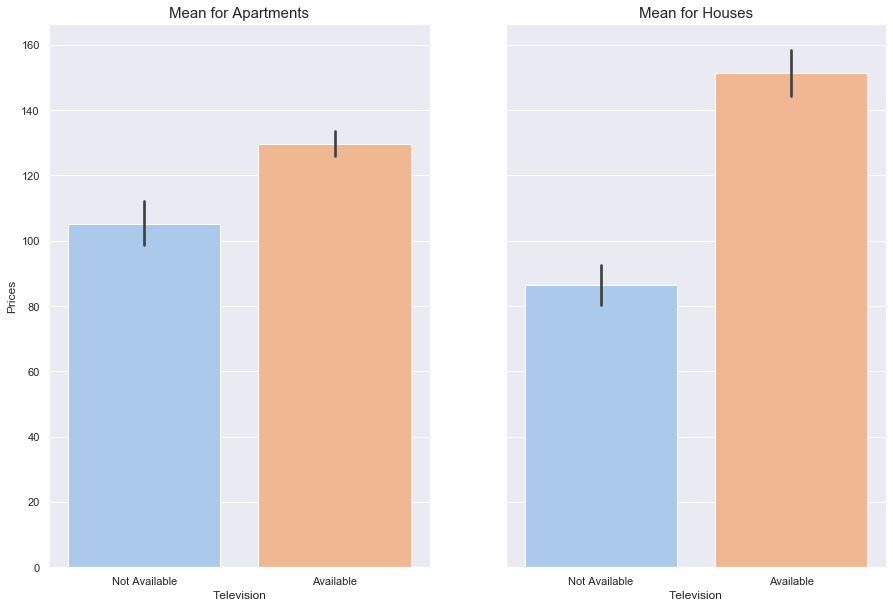

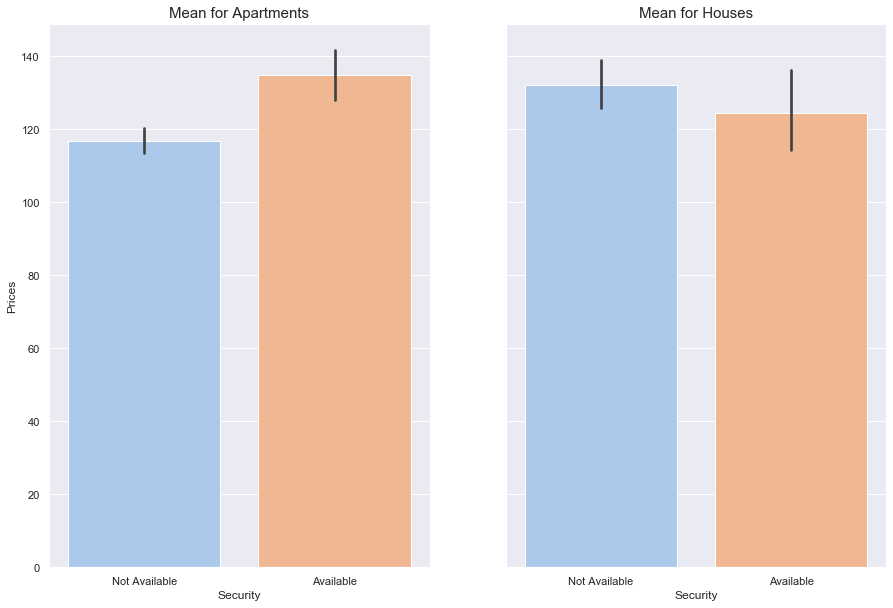

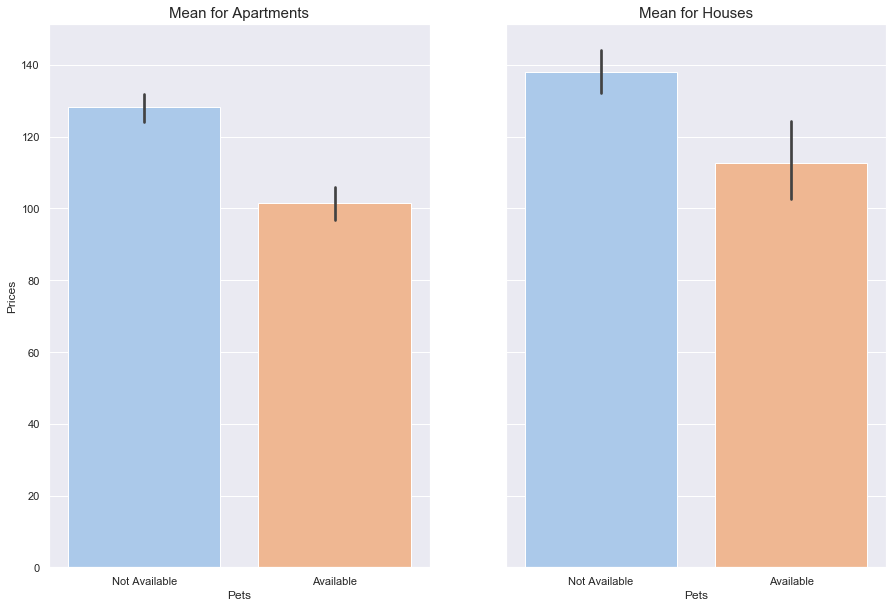

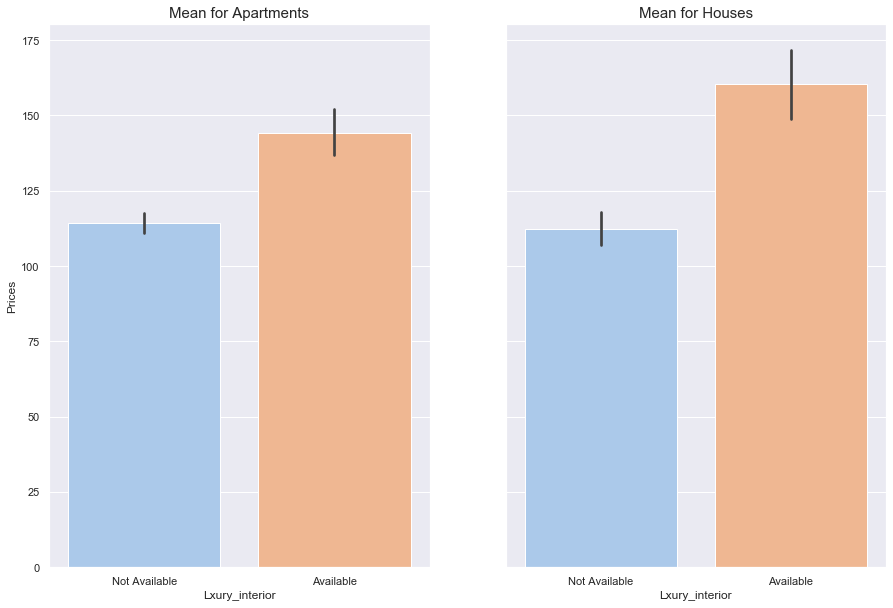

In [65]:
ls_am=df_fin_cal.loc[:,"Kitchen":"Lxury_interior"].columns.to_list()

df_ap=df_fin_cal.query("property_type=='Apartment'")
df_ho=df_fin_cal.query("property_type=='House'")

lab=['Not Available','Available']

for i in ls_am:
    f, axes = plt.subplots(1, 2, figsize=(15, 10), sharey=True)
    sns.barplot(x=i, y="price", data=df_ap,palette="pastel", ax=axes[0])
    sns.barplot(x=i, y="price", data=df_ho,palette="pastel", ax=axes[1])
    axes[0].set_title("Mean for Apartments",size=15)
    axes[1].set_title("Mean for Houses",size=15)
    axes[0].set_ylabel("Prices")
    axes[1].set_ylabel("")
    axes[0].set_xticklabels(lab)
    axes[1].set_xticklabels(lab)
    plt.show();    

Comapring the mean values for the availability of an amenity in Houses and Apartments,reveals some interesting difference. Listings offering a Kitchen have a mean higher price - regardless the property type.  This is also valid for Internet, Family friendliness , Television and Luxury interiors!  

Some specific differences occur, for example Houses in which pets are allowed have a higher mean price, than houses without pets allowance. For Apartments the prices are near equal. Another example are Wheelchair Accessibility, where Houses seem to benefit more from. 

Offering breakfast is something, that is related to higher mean prices in Apartments. 

The last example indicates something, which has to be taken into account: Some amities will occur more often in favor of the property type. Offering breakfast might occur less, when renting an own house in contrast allowing pets might occur more often. 

## Q4 What factor has the most impact on Pricing ? 

In [143]:
# Dropping some vars (id, cleaning fee (too much missign values) etc)
df_model=df_fin_cal[['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified',
                     'neighbourhood_group_cleansed','property_type', 'room_type', 
                     'accommodates', 'bathrooms', 'bedrooms','beds', 'bed_type',
                     'price', 'guests_included','extra_people', 'minimum_nights',
                     'number_of_reviews','review_scores_accuracy', 'review_scores_cleanliness',
                     'review_scores_checkin', 'review_scores_communication',
                     'review_scores_location', 'review_scores_value', 'instant_bookable',
                     'cancellation_policy', 'require_guest_profile_picture',
                     'require_guest_phone_verification', 'calculated_host_listings_count',
                     'reviews_per_month', 'Kitchen', 'Internet', 'Free Parking on Premises',
                     'Family/Kid Friendly', 'Elevator in Building',
                     'Laptop Friendly Workspace', '24-Hour Check-in', 'Pets Allowed',
                     'Wheelchair Accessible', 'Breakfast', 'Suitable for Events',
                     'Smoking Allowed', 'Protection', 'Sanitary', 'Essential', 'Home_items',
                     'Television', 'Security', 'Pets', 'Lxury_interior','years_exp']]

In [144]:
df_model.dtypes

host_is_superhost                    object
host_has_profile_pic                 object
host_identity_verified               object
neighbourhood_group_cleansed         object
property_type                        object
room_type                            object
accommodates                          int64
bathrooms                           float64
bedrooms                            float64
beds                                float64
bed_type                             object
price                               float64
guests_included                       int64
extra_people                        float64
minimum_nights                        int64
number_of_reviews                     int64
review_scores_accuracy              float64
review_scores_cleanliness           float64
review_scores_checkin               float64
review_scores_communication         float64
review_scores_location              float64
review_scores_value                 float64
instant_bookable                

In [145]:
# Creating a numvar-list for corr_test and Standard-Scaling 
# and a cat_vars list for dummy encoding 
num_vars=['accommodates','bedrooms','bathrooms','beds','guests_included','extra_people',
         'minimum_nights','number_of_reviews','review_scores_accuracy','review_scores_cleanliness',
         'review_scores_checkin','review_scores_communication','review_scores_location',
          'review_scores_value','reviews_per_month','years_exp']

# Label encoding would not make sense, as the data is of nominal type. 
# Wether neighbourhood, property_type or bed_type - those var's cannot be rankend
cat_vars = ['neighbourhood_group_cleansed', 'property_type', 'room_type',\
                      'bed_type', 'cancellation_policy']

### Create dummies 

In [146]:
# Some variable must be convertet to dummies
df_model_dum = df_model.copy()

for v in cat_vars:
    dummies = pd.get_dummies(df_model[v],prefix=v,drop_first=False, dummy_na=False)
    df_model_dum=pd.concat([dummies,df_model_dum],axis=1)
    df_model_dum=df_model_dum.drop(v,axis=1)

In [147]:
df_model_dum

,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Entire home/apt,room_type_Private room,...,Smoking Allowed,Protection,Sanitary,Essential,Home_items,Television,Security,Pets,Lxury_interior,years_exp
0,0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,1,1,0,0,0,5
1,0,0,1,0,0,0,0,1,1,0,...,0,1,1,1,1,1,1,0,0,3
2,0,0,1,0,0,0,0,1,1,0,...,0,1,1,1,1,1,0,1,1,2
3,0,0,1,0,0,0,0,1,1,0,...,0,1,1,1,0,1,0,0,0,5
4,0,0,1,0,0,0,0,1,0,1,...,0,1,1,1,0,0,0,0,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3167,0,0,1,0,0,0,0,1,1,0,...,0,1,1,1,1,1,1,1,0,5
3168,0,1,0,0,0,0,0,1,1,0,...,0,1,1,1,1,1,1,0,1,2
3169,0,1,0,0,0,0,0,1,1,0,...,0,1,1,1,1,0,0,0,1,4
3170,0,0,1,0,0,0,0,1,1,0,...,0,1,1,1,1,1,0,0,0,1


### Imputing missing values 

In [148]:
pd.set_option('display.max_rows', 200)
df_model_dum.isnull().sum()

cancellation_policy_flexible                         0
cancellation_policy_moderate                         0
cancellation_policy_strict                           0
bed_type_Airbed                                      0
bed_type_Couch                                       0
bed_type_Futon                                       0
bed_type_Pull-out Sofa                               0
bed_type_Real Bed                                    0
room_type_Entire home/apt                            0
room_type_Private room                               0
room_type_Shared room                                0
property_type_Apartment                              0
property_type_Bed & Breakfast                        0
property_type_Boat                                   0
property_type_Bungalow                               0
property_type_Cabin                                  0
property_type_Camper/RV                              0
property_type_Chalet                                 0
property_t

Bathrooms, Bedrooms and some review-scores have missing values.

In [149]:
# Creating a frame with property relevant data to impute missing values.
df_impute_prop=df_model_dum[['bedrooms','bathrooms','room_type_Entire home/apt','room_type_Private room', 
              'room_type_Shared room','property_type_Apartment', 'property_type_Bed & Breakfast',
              'property_type_Boat','property_type_Bungalow','property_type_Cabin',
              'property_type_Camper/RV','property_type_Chalet','property_type_Condominium',                           
              'property_type_Dorm','property_type_House','property_type_Loft','property_type_Other',                                  
              'property_type_Tent','property_type_Townhouse','property_type_Treehouse',
              'property_type_Yurt']]     

In [150]:
# Imputing values by an iterative Imputing with KNeighborsRegressor 
imp_prop=IterativeImputer(missing_values=np.nan,random_state=0,initial_strategy='median'\
                         ,max_iter=40, estimator=KNeighborsRegressor(n_neighbors=10))

# Imputing bathrooms 
df_model_dum['bathrooms']=imp_prop.fit_transform(df_impute_prop['bathrooms'].\
                                                 values.reshape(-1, 1)).round()

# Impujting bedrooms 
df_model_dum['bedrooms']=imp_prop.fit_transform(df_impute_prop['bedrooms'].\
                                                values.reshape(-1, 1)).round()

In [151]:
pd.set_option('display.max_rows', 200)
df_model_dum.isnull().sum()

cancellation_policy_flexible                         0
cancellation_policy_moderate                         0
cancellation_policy_strict                           0
bed_type_Airbed                                      0
bed_type_Couch                                       0
bed_type_Futon                                       0
bed_type_Pull-out Sofa                               0
bed_type_Real Bed                                    0
room_type_Entire home/apt                            0
room_type_Private room                               0
room_type_Shared room                                0
property_type_Apartment                              0
property_type_Bed & Breakfast                        0
property_type_Boat                                   0
property_type_Bungalow                               0
property_type_Cabin                                  0
property_type_Camper/RV                              0
property_type_Chalet                                 0
property_t

In [152]:
# As reviews are a product of a every attribute, i am going the take the full set 
# as basis for imputation 
imp_rev=IterativeImputer(missing_values=np.nan,random_state=0,initial_strategy='mean'\
                         ,max_iter=40, estimator=KNeighborsRegressor(n_neighbors=10))

rev_list=['review_scores_accuracy','review_scores_cleanliness','review_scores_checkin',\
          'review_scores_communication','review_scores_location', 'review_scores_value']                                 

for r in rev_list: 
    df_model_dum[r]=imp_prop.fit_transform(df_model_dum[r].\
                                           values.reshape(-1, 1)).round()

### Standardscaling

In [153]:
# Creating copy
df_scale=df_model_dum.copy()

## Applying Standardscaling 
#reduce to num-vars
scale_feat=df_model_dum[num_vars]
#define scaler 
scaler = StandardScaler().fit(scale_feat.values)
#fitting scaler 
features = scaler.transform(scale_feat.values)
#Assigning scaler 
df_scale[num_vars] = features

df_scale.head(10)

,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,room_type_Entire home/apt,room_type_Private room,...,Smoking Allowed,Protection,Sanitary,Essential,Home_items,Television,Security,Pets,Lxury_interior,years_exp
0,0,1,0,0,0,0,0,1,1,0,...,0,0,1,0,1,1,0,0,0,1.378265
1,0,0,1,0,0,0,0,1,1,0,...,0,1,1,1,1,1,1,0,0,0.085008
2,0,0,1,0,0,0,0,1,1,0,...,0,1,1,1,1,1,0,1,1,-0.561621
3,0,0,1,0,0,0,0,1,1,0,...,0,1,1,1,0,1,0,0,0,1.378265
4,0,0,1,0,0,0,0,1,0,1,...,0,1,1,1,0,0,0,0,0,2.024894
5,0,1,0,0,0,0,0,1,0,1,...,0,1,1,1,0,0,0,0,0,0.731636
6,0,0,1,0,0,0,0,1,0,1,...,0,0,1,1,0,0,0,1,0,0.731636
7,0,0,1,0,0,0,0,1,0,1,...,0,1,1,1,1,1,0,0,1,0.731636
8,0,0,1,0,0,0,0,1,1,0,...,0,1,1,1,1,1,1,0,0,0.085008
9,0,1,0,0,0,0,0,1,1,0,...,0,1,1,1,1,1,1,0,0,2.024894


### Checking Correlations 

Text(0.5, 1, 'Test for Multicollinearity')

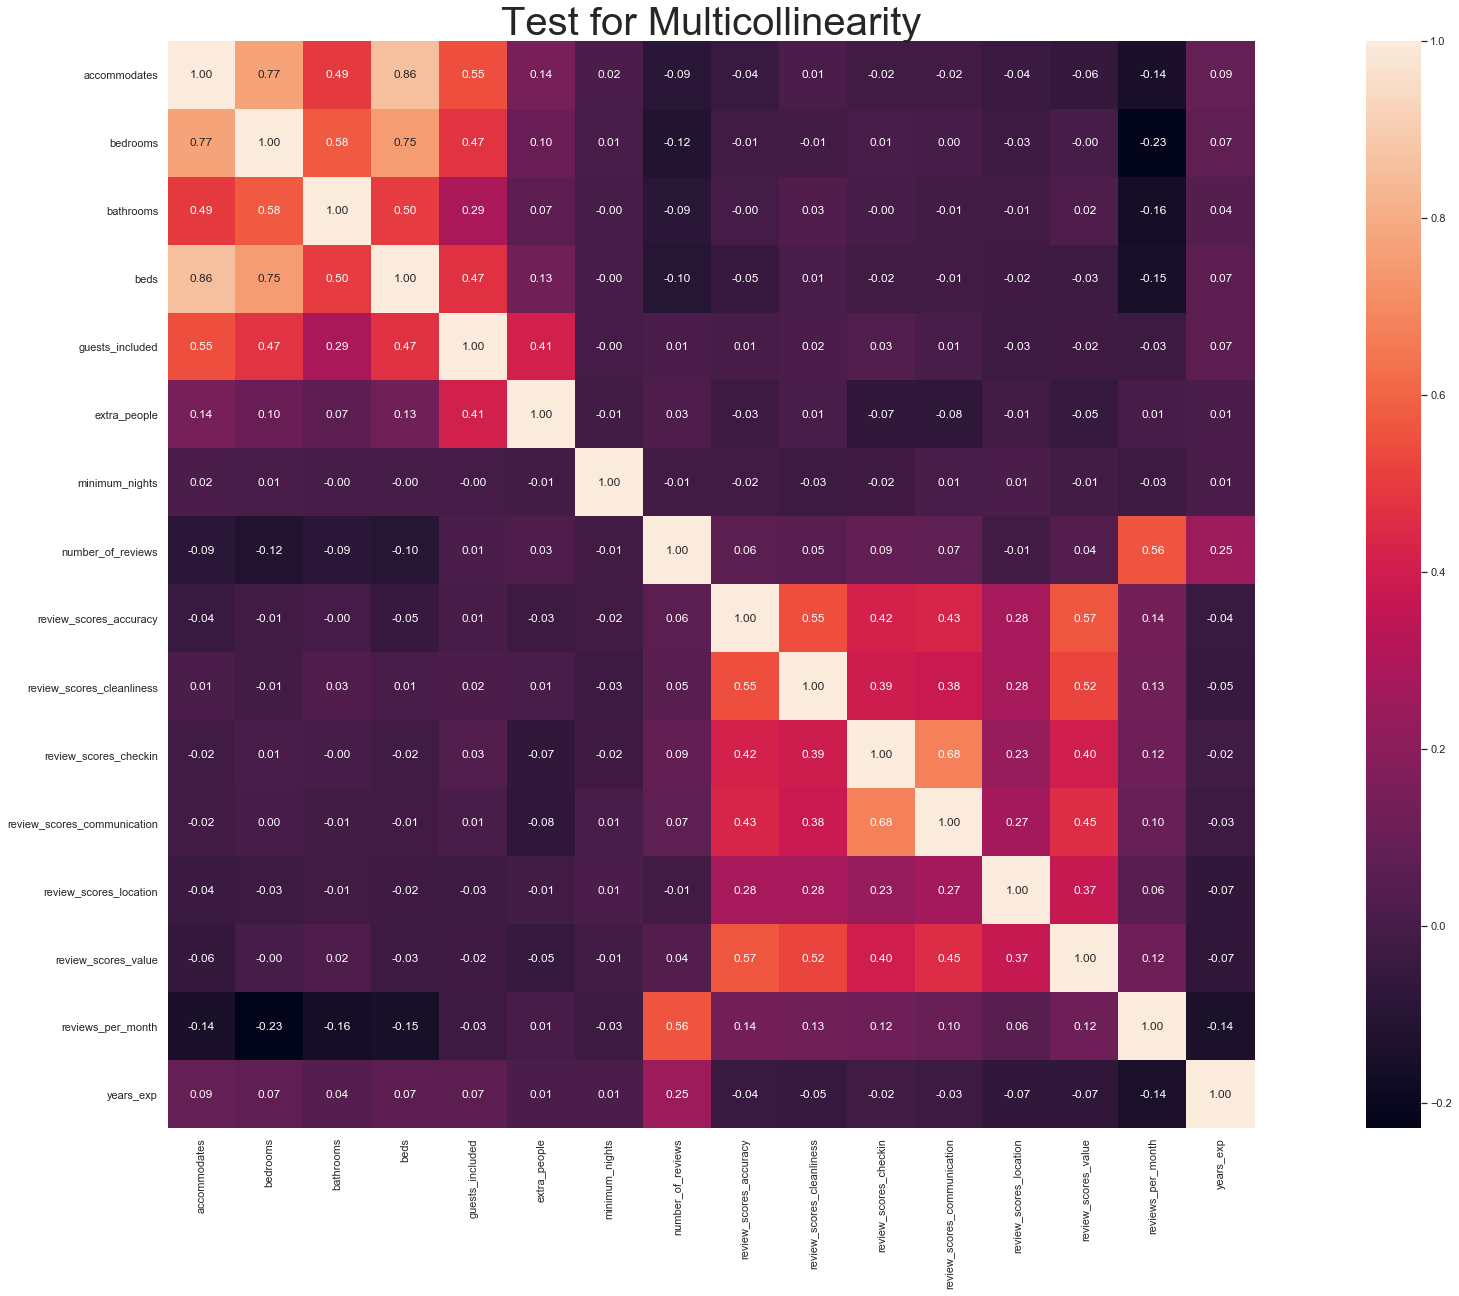

In [154]:
corr_val=df_scale[num_vars].corr()
plt.figure(figsize=(40, 20))
sns.heatmap(corr_val, cbar = True, annot=True, square = True, fmt = '.2f',
              yticklabels = num_vars, xticklabels = num_vars)
plt.title('Test for Multicollinearity',size=40)

The test for multikolinearity reveals that accommodation has a high correlation with the number of bedrooms and the number of beds. Both - Beds and bedrooms - will be dropped! 

In [155]:
df_final=df_scale.drop(['bedrooms','beds'],axis=1)

### RandomForestRegressor

The first thing I am interested in, is which of the available variables have an influence on pricing. I am particularly interested in the role of neighbourhood, property type and especially amenities. In the previous studies, differences were found depending on the family friendliness, luxury amenities, etc. 
First, I grow a basic RandomForrest, then I try to fine-tune it with GridSearch to improve the Mean absolute error.   

In [156]:
df_rf=df_final.copy()

In [158]:
# Splitting dependend var and independent vars
Y=df_rf['price']
X=df_rf[df_rf.columns.difference(['price'])]

In [159]:
# Train, test-split 
X_train, X_test,y_train,y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

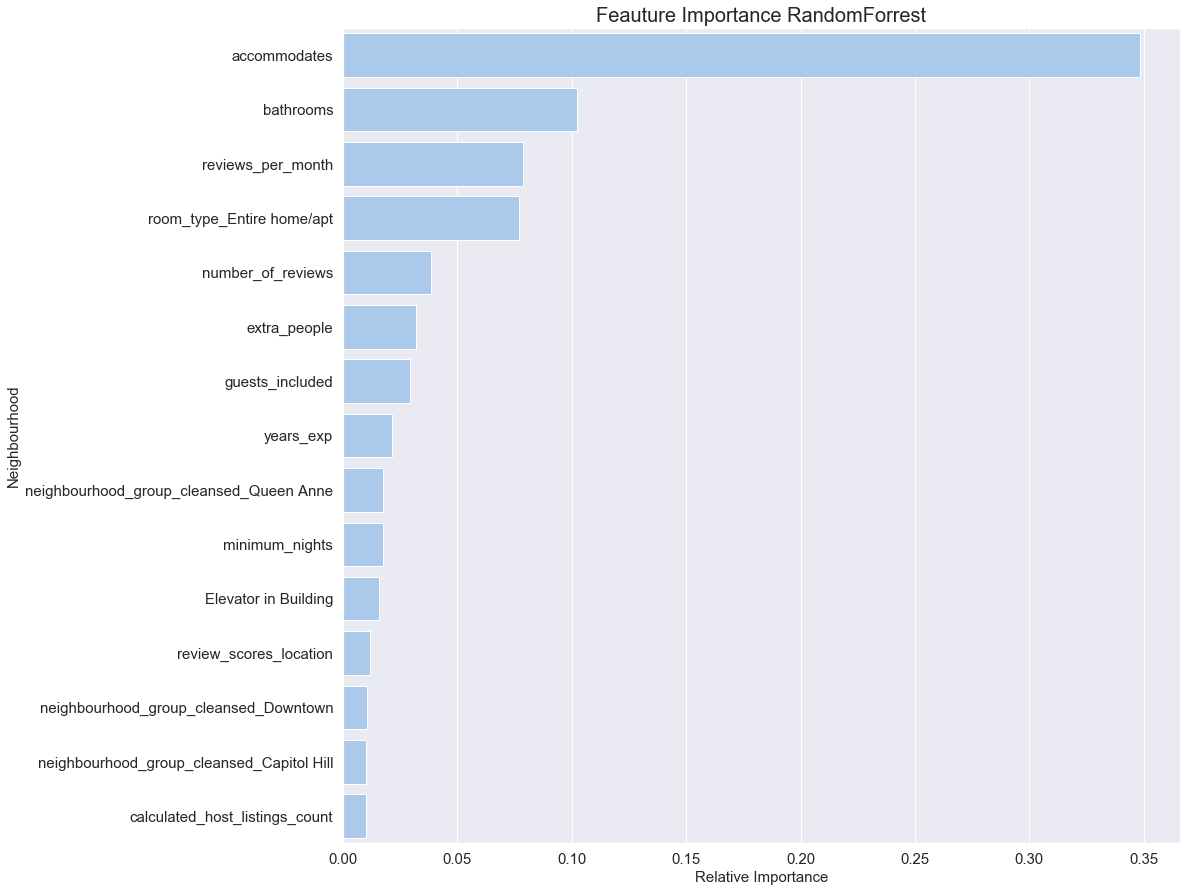

R^2 Training Score: 0.94 
R^2 Test Score: 0.63                           
Mean absolute Error: 33.92


In [160]:
# Basic RandomForrest
rf = RandomForestRegressor(random_state = 12)

# Fitting the model 
rf_uop=rf.fit(X_train, y_train)

importances = list(rf.feature_importances_)
feature_importances = pd.DataFrame(rf_uop.feature_importances_,index = X_train.columns,
                                   columns=['importance']).sort_values('importance', \
                                                                        ascending=False)
# Reducing on Top feautures 
rf_uop_feat=feature_importances.head(15).sort_values(by='importance',ascending=False).reset_index()

# Computing mae
test_mae = X_test.copy()
pred = rf_uop.predict(test_mae)
mae=mean_absolute_error(y_test, pred)


# Building plot 
sns.set(font_scale = 1)
f= plt.figure(figsize=(15, 15))
sns.set_color_codes("pastel")
bar=sns.barplot(x="importance", y="index", data=rf_uop_feat, color='b')
#bar.set_xticklabels(bar.get_xticklabels(),rotation=45,size=10)
bar.axes.set_title("Feauture Importance RandomForrest", size=20)
bar.set_xlabel("Relative Importance",fontsize=15)
bar.set_ylabel("Neighbourhood",fontsize=15)
bar.tick_params(labelsize=15)
plt.show();


print('R^2 Training Score: {:.2f} \nR^2 Test Score: {:.2f} \
                          \nMean absolute Error: {:.2f}'.format(rf_uop.score(X_train, y_train), 
                                                        rf_uop.score(X_test, y_test),
                                                              mae))


The first calculation did not do too badly: With a mean price miscalculation about 34 dollars and an explained variance of 63 percent in the test data set, it is a decent result. Not 

Not surprisingly, accommodates is the top feature. This is seems ad-hoc logical, as the more room you offer, the more money you can demand. Accommodates is followed by bathrooms, Reviews per Month and Roomtype Apartmant/House. 

In the next step I try to optimize the result a bit with a GridSearch. 

In [183]:
# Using my GreadSearch function to find the best params 
start=time.time()
best_score , best_params= grid_rf(X_train, y_train)
end=time.time()
print("Calculation time of GridSearch was {:.2f} Minutes ".format((end-start)/60))

C:\Users\ashra\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Calculation time of GridSearch was 13.75 Minutes 


In [184]:
print("The Best params [{}] achieve a MAE of {:.2f}".format(best_params,best_score))

The Best params [{'bootstrap': True, 'max_depth': 35, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 1000, 'oob_score': True}] achieve a MAE of -31.42


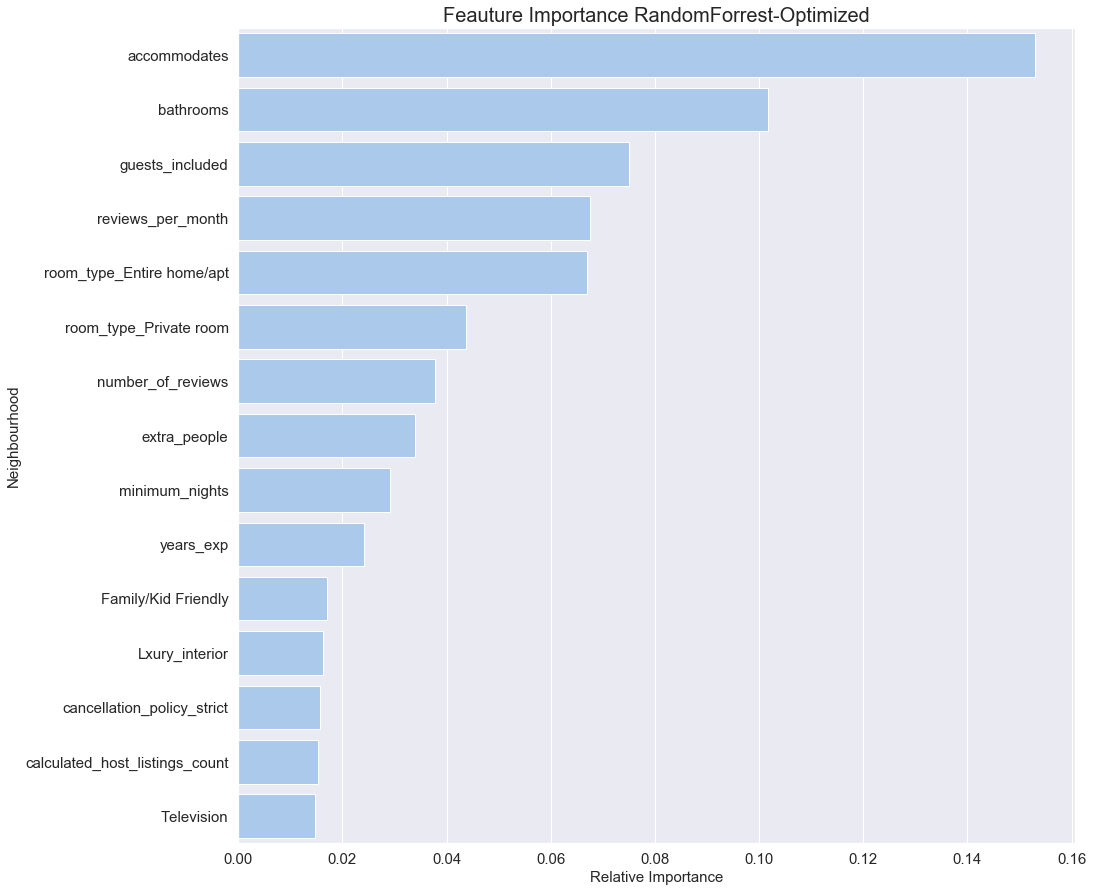

R^2 Training Score: 0.94 
R^2 Test Score: 0.63                           
Mean absolute Error: 33.40


In [185]:
# Rerunning RandomForest with best_params
best_model = RandomForestRegressor(random_state = 12,n_jobs=-1).set_params(**best_params)
rf_op=best_model.fit(X_train,y_train)
feature_importances_opt = pd.DataFrame(rf_op.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
# Reducing on Top feautures 
rf_op_feat=feature_importances_opt.head(15).sort_values(by='importance',ascending=False)\
                                                                        .reset_index()

#Computing mae
test_mae_op = X_test.copy()
pred_op = rf_op.predict(test_mae_op)
mae_op=mean_absolute_error(y_test, pred_op)


# Building plot 
sns.set(font_scale = 1)
f= plt.figure(figsize=(15, 15))
sns.set_color_codes("pastel")
bar=sns.barplot(x="importance", y="index", data=rf_op_feat, color='b')
#bar.set_xticklabels(bar.get_xticklabels(),rotation=45,size=10)
bar.axes.set_title("Feauture Importance RandomForrest-Optimized", size=20)
bar.set_xlabel("Relative Importance",fontsize=15)
bar.set_ylabel("Neighbourhood",fontsize=15)
bar.tick_params(labelsize=15)
plt.show();


print('R^2 Training Score: {:.2f} \nR^2 Test Score: {:.2f} \
                          \nMean absolute Error: {:.2f}'.format(rf_op.score(X_train, y_train), 
                                                        rf_op.score(X_test, y_test),
                                                              mae_op))

Rerunning the model gives a little improvement and lowers the MAE to around $ 33. With an high R^2 about 0.94 on the training set and a lower R^2 of 0.63 on the test set, their might be some overfitting, which should be examined in further models. 

Besides that, there might be some aspects in terms of content, which should be considered. I assume some interactions between several variables, for example the number of bathrooms and accommondates. Even if the correlation is medium strong, both are logically related. 
So there might be some further options in engineering new feautres. 

Apart from that, there are some elements individually influencing the host and thus determine the price which were not available. I had no data on fixed costs like electricity, credit rates etc. 

In [201]:
# Saving model 
pickle.dump(rf_op, open('RandomForrestReg.pkl', 'wb'))